# Extracting data from web pages 
✅ In this noteBook we are going to extract data from relevant webpages relative to our needs based on links using Langchain `WebBaseLoader` so we can feed the documents list to RAG after converting into Vector Embeddings
 than we are going to preprocess them by splitting , embedding and saving it to a vector database and the database we are going to use is `CHROMADB`

 
 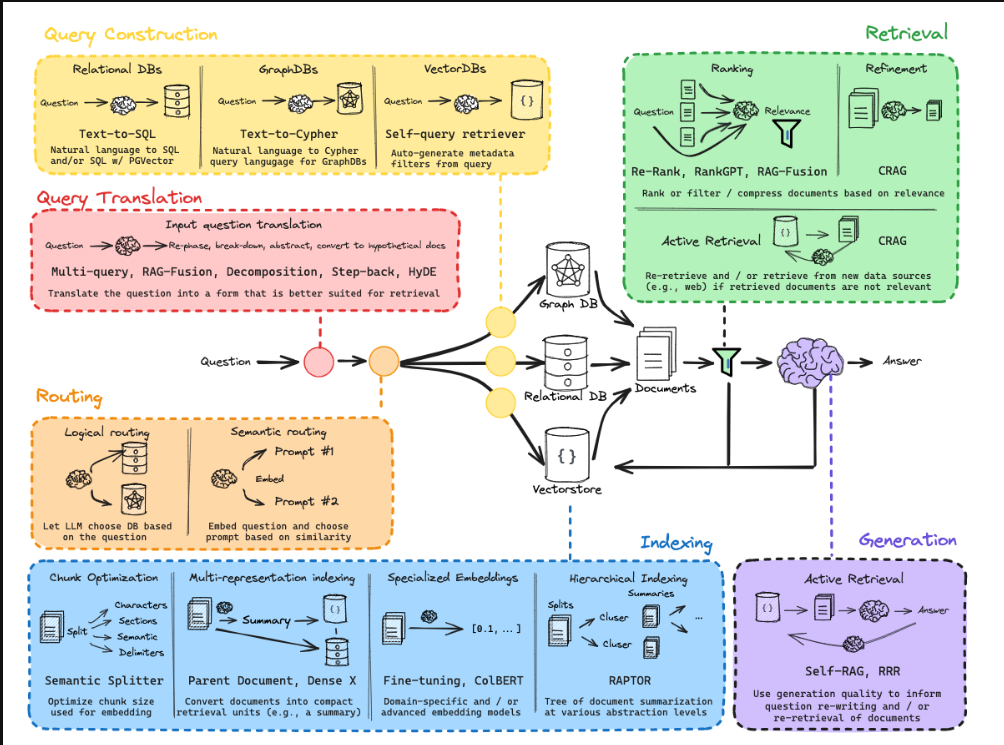

 the PDFS will be processed in another notebook 😊

In [14]:
# %pip install -qU langchain-community beautifulsoup4

In [15]:
# %pip install langchain-unstructured

In [16]:
# pip cache purge


In [17]:
# pip install langchain sentence-transformers chromadb


In [18]:
# %pip install ollama

In [19]:
# pip install -U sentence-transformers


In [20]:
# pip install langchain_openai

In [21]:
# # pip install -U langchain-huggingface
# %pip install -U langchain-ollama
# %pip install chromadb
# %pip install chromadb
# ! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain

# Importing Library that we are gonna use 

In [23]:
from typing import List
from langchain_core.documents import Document
from langchain_community.document_loaders import PyPDFLoader, WebBaseLoader
from langchain_unstructured import UnstructuredLoader
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import os
import bs4
from sentence_transformers import SentenceTransformer
from langchain_huggingface import HuggingFaceEmbeddings
import ollama
from langchain.embeddings import OllamaEmbeddings, HuggingFaceEmbeddings
from langchain_ollama import OllamaEmbeddings
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import chromadb
import uuid
import pandas as pd 
from sklearn.manifold import TSNE
from langchain.embeddings import HuggingFaceEmbeddings
import re
import string

In [24]:
# embeddings_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

## Loading the model we are gonne use for transorming to embedding 
the model is open source and is good one for embedding to be used later in retrival 

In [26]:
def clean_text(text):
    '''this functionn clean the output of the webmloader '''
    text = text.replace('\xa0', ' ')
    text = re.sub(r'[\n\r\t]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

In [27]:
# embeddings_model = SentenceTransformer("HIT-TMG/KaLM-embedding-multilingual-mini-instruct-v1.5")
embeddings_model = HuggingFaceEmbeddings(model_name="HIT-TMG/KaLM-embedding-multilingual-mini-instruct-v1.5")

C:\Users\belha\AppData\Local\Temp\ipykernel_26744\612398256.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings_model = HuggingFaceEmbeddings(model_name="HIT-TMG/KaLM-embedding-multilingual-mini-instruct-v1.5")
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


# Configure `ChromaDB` for our work 

In [29]:
# chroma_client.delete_collection(name="my_dataaaa")  # Deletes "my_dataaaa"


In [30]:
chroma_db_path = "./chroma_db"  
chroma_client = chromadb.PersistentClient(path=chroma_db_path)

In [31]:
data  = chroma_client.get_or_create_collection(name="my_dataaaa")

#  <p style="color: orange;">Document 0 Masteres-Procedure-de-Depot</p>

In [33]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/pages/152/Masteres-Procedure-de-Depot",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
Masteres_Procedure_de_Depot = loader.load()

In [34]:
Masteres_Procedure_de_Depot = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in Masteres_Procedure_de_Depot]
Masteres_Procedure_de_Depot

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/152/Masteres-Procedure-de-Depot'}, page_content="Les étudiants ayant accompli leurs stages de mastère et achevé la rédaction de leur mémoire doivent déposer à l'administration, au bureau des mastères, les éléments suivants : Une demande d'autorisation de soutenance faite au nom du Doyen et signée par l'encadrant universitaire, Le rapport de l'encadrant universitaire résumant brièvement les travaux effectués par le candidat, Une copie du mémoire de mastère, Un CD contenant le mémoire sous forme de fichier pdf. Une copie signée du mail de confirmation de la réception du formulaire de renseignements (formulaire ci-dessous). Une copie de la Carte d'Identité Nationale. NB : Pour les étudiants des classes de mastère professionnel, il faut faire le dépôt en ligne de votre rapport de mastère dans l'espace extranet sous la rubrique stage obligatoire -> lettre d'autorisation de dépôt et joindre les documents suivants à votre dossier de 

## spliiting into chunks the doc0

In [36]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100)
splits1 = text_splitter.split_documents( Masteres_Procedure_de_Depot)

In [37]:
splits1

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/152/Masteres-Procedure-de-Depot'}, page_content="Les étudiants ayant accompli leurs stages de mastère et achevé la rédaction de leur mémoire doivent déposer à l'administration, au bureau des mastères, les éléments suivants : Une demande d'autorisation de soutenance faite au nom du Doyen et signée par l'encadrant universitaire, Le rapport de l'encadrant universitaire résumant brièvement les travaux effectués par le candidat, Une copie du mémoire de mastère, Un CD contenant le mémoire sous forme de fichier pdf. Une copie signée du mail de confirmation de la réception du formulaire de renseignements (formulaire ci-dessous). Une copie de la Carte d'Identité Nationale. NB : Pour les étudiants des classes de mastère professionnel, il faut faire"),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/152/Masteres-Procedure-de-Depot'}, page_content="d'Identité Nationale. NB : Pour les étudiants des classes de mastère profession

## Saving to chromadb in data 

In [39]:
contents1 = [doc.page_content for doc in splits1]
metadata1 = [doc.metadata for doc in splits1]

In [40]:
embeddings1 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits1], 
    #normalize_embeddings=True,
    #batch_size=256, 
    #show_progress_bar=True
    )
print(embeddings1)

[[-0.01606520265340805, 0.06428936868906021, 0.037065669894218445, 0.008198750205338001, -0.0566006638109684, 0.006979786325246096, -0.0006413614610210061, -0.027131272479891777, 0.03184695914387703, -0.0023110490292310715, -0.017145240679383278, 0.03505208343267441, 0.003981538582593203, -0.030306518077850342, 0.053325261920690536, 0.005793089512735605, -0.08905588835477829, 0.03773099556565285, -0.009006982669234276, 0.009064833633601665, -0.07528713345527649, 0.025582242757081985, -0.01606595329940319, 0.07389332354068756, -0.016282113268971443, 0.09616045653820038, 0.03502005338668823, -0.034780606627464294, -0.028488721698522568, 0.05501420050859451, -0.0018126379000023007, -0.08251295983791351, -0.010377085767686367, -0.045406684279441833, -0.0034837634302675724, 0.0002428436855552718, -0.007599416188895702, 0.05240064486861229, 0.05685298517346382, 0.0008641910972073674, -0.02809344045817852, -0.024872858077287674, -0.008599456399679184, -0.015190756879746914, -0.045901082456111

In [41]:
ids = [str(uuid.uuid4()) for _ in range(len(contents1))]

In [42]:
data.add(
    documents=contents1,
    embeddings=embeddings1,
    metadatas=metadata1,
    ids=ids
)

In [43]:
# visulizing in a dataframe 
data_dict = {
    "ID": ids,
    "Document": contents1,
    "Metadata": metadata1,
    "Embedding Shape": [np.array(embed).shape for embed in embeddings1],
}

df = pd.DataFrame(data_dict)
df.tail()

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"


In [44]:
def append_data(contents, metadata, embeddings):
    '''this function will append the embeddings and metadata and 
    the document into the data_dict so we can visulize how it looks in chrom '''
    global df
    new_ids = list(range(len(df) + 1, len(df) + 1 + len(contents)))
    
    data_dict["ID"].extend(new_ids)
    data_dict["Document"].extend(contents)
    data_dict["Metadata"].extend(metadata)
    data_dict["Embedding Shape"].extend([np.array(embed).shape for embed in embeddings])
    
    df = pd.DataFrame(data_dict)


#  <p style="color: orange;">Document 1 Theses-Inscriptions-etProcedure-de-Depot</p>

In [46]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/pages/147/Theses-Inscriptions-etProcedure-de-Depot",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
Theses_Inscriptions_etProcedure_de_Depot = loader.load()

In [47]:
Theses_Inscriptions_etProcedure_de_Depot = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in Theses_Inscriptions_etProcedure_de_Depot]
Theses_Inscriptions_etProcedure_de_Depot


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/147/Theses-Inscriptions-etProcedure-de-Depot'}, page_content="Inscriptions en thèse Pour les inscriptions en thèse, et selon qu'elles soient nouvelles ou dans le cadre d'un Renouvellement, les pièces demandées sont : Nouvelles inscriptions Une demande d'inscription (formulaire à télécharger doc, pdf), Une fiche de thèse remplie (formulaire téléchargable à partir du site web theses-tn.net), Une page de présentation du sujet de thèse, La charte des études doctorales signée (ED-MDM : doc pdf, ED-STI : doc pdf), Les diplômes obtenus à partir du baccalauréat (avec les relevés des notes pour les candidats ingénieurs), Une photocopie de la carte d'identité, Une photo d'identité, Fiche Directeur de thèse de doctorat (Fiche) Renouvellement des inscriptions Une demande d'inscription (formulaire à télécharger doc, pdf), Un rapport d'avancement des travaux de recherche du candidat, établi par le directeur de thèse, Une demande de dérogati

## splitting into chunks the doc1

In [49]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits2 = text_splitter.split_documents( Theses_Inscriptions_etProcedure_de_Depot)

In [50]:
splits2

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/147/Theses-Inscriptions-etProcedure-de-Depot'}, page_content="Inscriptions en thèse Pour les inscriptions en thèse, et selon qu'elles soient nouvelles ou dans le cadre d'un Renouvellement, les pièces demandées sont : Nouvelles inscriptions Une demande d'inscription (formulaire à télécharger doc, pdf), Une fiche de thèse remplie (formulaire téléchargable à partir du site web theses-tn"),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/147/Theses-Inscriptions-etProcedure-de-Depot'}, page_content=".net), Une page de présentation du sujet de thèse, La charte des études doctorales signée (ED-MDM : doc pdf, ED-STI : doc pdf), Les diplômes obtenus à partir du baccalauréat (avec les relevés des notes pour les candidats ingénieurs), Une photocopie de la carte d'identité, Une photo d'identité, Fiche Directeur de thèse de doctorat (Fiche) Renouvellement des inscriptions Une demande d'inscription (formulaire à télécharger doc,

In [51]:
contents2= [doc.page_content for doc in splits2]
metadata2 = [doc.metadata for doc in splits2]

In [52]:
embeddings2 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits2], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings2)

[[-0.05462244525551796, 0.03269156441092491, 0.022412778809666634, 0.020189063623547554, -0.02407241053879261, -0.008482317440211773, -0.008416659198701382, -0.057199690490961075, -0.004352032206952572, -0.0076567912474274635, -0.05412035807967186, 0.02696048840880394, 0.014326191507279873, -0.005852507892996073, 0.05596357583999634, -0.0009486164199188352, -0.07797332108020782, 0.04037031531333923, -0.030177632346749306, -0.015871601179242134, -0.039730098098516464, 0.03467128053307533, -0.019087396562099457, 0.06855237483978271, -0.033378127962350845, 0.07412263751029968, 0.0169011689722538, -0.02956952340900898, -0.02713623084127903, 0.0014992158394306898, 0.0037160112988203764, -0.040848128497600555, -0.01818094588816166, -0.050538912415504456, 0.024038296192884445, 0.04901749640703201, -0.024652421474456787, 0.025653794407844543, 0.0655699223279953, 0.01687523163855076, -0.024044858291745186, -0.0030828844755887985, -0.014068213291466236, 0.0015195400919765234, -0.0317189544439315

In [53]:
ids2= [str(uuid.uuid4()) for _ in range(len(contents2))]

In [54]:
data.add(
    documents=contents2,
    embeddings=embeddings2,
    metadatas=metadata2,
    ids=ids2
)

In [55]:
append_data(contents2, metadata2, embeddings2)


In [56]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"


#  <p style="color: orange;"> Document 2  رشة_بعنوان_أهمية_الصحة_النفسية</p>

In [58]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/articles/4798/%D9%88%D8%B1%D8%B4%D8%A9-%D8%A8%D8%B9%D9%86%D9%88%D8%A7%D9%86-%D8%A3%D9%87%D9%85%D9%8A%D8%A9-%D8%A7%D9%84%D8%B5%D8%AD%D8%A9-%D8%A7%D9%84%D9%86%D9%81%D8%B3%D9%8A%D8%A9",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
warcha_mental_health = loader.load()

In [59]:
warcha_mental_health = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in warcha_mental_health]
warcha_mental_health

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/4798/%D9%88%D8%B1%D8%B4%D8%A9-%D8%A8%D8%B9%D9%86%D9%88%D8%A7%D9%86-%D8%A3%D9%87%D9%85%D9%8A%D8%A9-%D8%A7%D9%84%D8%B5%D8%AD%D8%A9-%D8%A7%D9%84%D9%86%D9%81%D8%B3%D9%8A%D8%A9'}, page_content='Date de création: 18 Fev 2025 / 307 Vue(s) تحت شعار "رمضانيات صحّية"، ستنتظم بساحة كلية العلوم بالمنستير حملة تقصّي وتثقيف صحّي حول : صحّة الفم والأسنان، الصّحّة النفسية، مرض السكري، ارتفاع ضغط الدم، عوامل الاختطار كالسلوكيات الغذائية غير السليمة والركود االبدني والسمنة والتدخين... وذلك يوم الإربعاء 19 فيفري 2025 بداية من الساعة 10:00 صباحا بالتعاون مع مجمع الصحّة الأساسية بالمنستير وقسم الطب الوقائي بمستشفى فطومة بورقيبة بالمنستير وإدارة الطب الوقائي بالإدارة الجهوية للصحة بالمنستير، فإنّ الدعوة مفتوحة للجميع (طلبة وإطار التدريس والإطار الإداري والفني والعملة بكلية العلوم بالمنستير) للحضور بكثافة.')]

## spitting doc 2 into chunks 

In [61]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits3 = text_splitter.split_documents( warcha_mental_health)

In [62]:
splits3

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/4798/%D9%88%D8%B1%D8%B4%D8%A9-%D8%A8%D8%B9%D9%86%D9%88%D8%A7%D9%86-%D8%A3%D9%87%D9%85%D9%8A%D8%A9-%D8%A7%D9%84%D8%B5%D8%AD%D8%A9-%D8%A7%D9%84%D9%86%D9%81%D8%B3%D9%8A%D8%A9'}, page_content='Date de création: 18 Fev 2025 / 307 Vue(s) تحت شعار "رمضانيات صحّية"، ستنتظم بساحة كلية العلوم بالمنستير حملة تقصّي وتثقيف صحّي حول : صحّة الفم والأسنان، الصّحّة النفسية، مرض السكري، ارتفاع ضغط الدم، عوامل الاختطار كالسلوكيات الغذائية غير السليمة والركود االبدني والسمنة والتدخين... وذلك يوم الإربعاء 19 فيفري 2025 بداية من الساعة 10:00 صباحا بالتعاون مع مجمع الصحّة الأساسية بالمنستير وقسم الطب الوقائي بمستشفى فطومة بورقيبة بالمنستير وإدارة الطب الوقائي بالإدارة الجهوية للصحة بالمنستير، فإنّ الدعوة مفتوحة للجميع (طلبة وإطار التدريس والإطار الإداري والفني والعملة بكلية العلوم بالمنستير) للحضور بكثافة.')]

In [63]:
contents3= [doc.page_content for doc in splits3]
metadata3 = [doc.metadata for doc in splits3]

In [64]:
embeddings3 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits3], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings3)

[[-0.024555925279855728, 0.024914376437664032, 0.04858752340078354, 0.012814581394195557, -0.02950797788798809, -0.0228866096585989, -0.027349166572093964, -0.032302405685186386, -0.0031705608125776052, -0.02180006168782711, -0.040678296238183975, 0.06073380261659622, 0.03555527701973915, 0.03791331872344017, 0.04993728548288345, -0.011445138603448868, -0.09557836502790451, 0.002001099521294236, -0.035752490162849426, -0.03299762308597565, -0.08257526904344559, 0.07249666005373001, -0.031595103442668915, 0.010631786659359932, -0.01966654136776924, 0.11203273385763168, -0.009432693012058735, -0.06295812875032425, -0.06240594759583473, 0.00017644863692112267, -0.017783714458346367, -0.05779324844479561, 0.014583472162485123, -0.020452020689845085, 0.0029285515192896128, -0.014942912384867668, -0.03315717726945877, 0.03035879321396351, 0.02142440713942051, -0.02094571851193905, -0.04372211545705795, -0.004347985610365868, -0.01511953491717577, -0.01352328434586525, -0.03948256000876427, -

In [65]:
ids3 = [str(uuid.uuid4()) for _ in range(len(contents3))]

In [66]:
data.add(
    documents=contents3,
    embeddings=embeddings3,
    metadatas=metadata3,
    ids=ids3
)

In [67]:
append_data(contents3, metadata3, embeddings3)


In [68]:
df.tail()

,ID,Document,Metadata,Embedding Shape
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


# <p style="color: orange;"> Document 3 festival-de-la-creativite-estudiantine</p>

In [70]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/articles/4795/festival-de-la-creativite-estudiantine",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
festival_de_la_creativite_estudiantinet = loader.load()

In [71]:
festival_de_la_creativite_estudiantinet = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in festival_de_la_creativite_estudiantinet]
festival_de_la_creativite_estudiantinet

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/4795/festival-de-la-creativite-estudiantine'}, page_content="Date de création: 14 Fev 2025 / 3248 Vue(s) Le festival est une occasion pour tous les étudiants de la Faculté des Sciences de Monastir de montrer leurs talents, échanger des connaissances et concourir, rencontrer de nouvelles personnes et de s'amuser. Le festival se déroule du 16 au 26 février 2025 à la Faculté des Sciences de Monastir. Les détails du programme sont dans le communiqué ci-dessous. Nous encourageons tous les étudiants à participer. Lien d'inscription aux évènements")]

## splitting the Doc3  into chunks 

In [73]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits4 = text_splitter.split_documents( festival_de_la_creativite_estudiantinet)

In [74]:
print(splits4[0].page_content)  # First chunk's content
print(splits4[0].metadata) 

Date de création: 14 Fev 2025 / 3248 Vue(s) Le festival est une occasion pour tous les étudiants de la Faculté des Sciences de Monastir de montrer leurs talents, échanger des connaissances et concourir, rencontrer de nouvelles personnes et de s'amuser. Le festival se déroule du 16 au 26 février 2025 à la Faculté des Sciences de Monastir. Les détails du programme sont dans le communiqué ci-dessous. Nous encourageons tous les étudiants à participer. Lien d'inscription aux évènements
{'source': 'https://fsm.rnu.tn/fra/articles/4795/festival-de-la-creativite-estudiantine'}


In [75]:
contents4= [doc.page_content for doc in splits4]
metadata4 = [doc.metadata for doc in splits4]

In [76]:
embeddings4 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits4], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings4)

[[-0.042631812393665314, 0.03438400477170944, 0.05440796911716461, 0.008631904609501362, -0.02661009505391121, -0.012151476927101612, -0.009445218369364738, -0.03311869129538536, 0.015383025631308556, -0.022191893309354782, -0.01642841286957264, 0.062290873378515244, 0.02668202854692936, 0.00515799131244421, 0.02358631044626236, -0.00805320031940937, -0.10398269444704056, 0.04021108150482178, -0.03203948587179184, -0.018473012372851372, -0.1301470547914505, 0.03488417714834213, -0.013065086677670479, 0.017124371603131294, -0.013497991487383842, 0.08268027752637863, 0.010303438641130924, -0.03891758620738983, -0.028478864580392838, 0.01782992109656334, 0.022859901189804077, -0.035626258701086044, 0.009781155735254288, -0.03982851654291153, -0.013454386033117771, -0.021999994292855263, -0.030066758394241333, 0.03906398266553879, 0.06569671630859375, -0.02315627411007881, -0.019327787682414055, 0.004045926500111818, -0.020599668845534325, -0.04241505637764931, -0.0306813046336174, -0.0446

In [77]:
ids4 = [str(uuid.uuid4()) for _ in range(len(contents4))]

In [78]:
data.add(
    documents=contents4,
    embeddings=embeddings4,
    metadatas=metadata4,
    ids=ids4
)

In [79]:
append_data(contents4, metadata4, embeddings4)


In [80]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


# <p style="color: orange;"> Document 4 bourses-d-alternance-2025</p>

In [82]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/articles/4813/bourses-d-alternance-2025",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
Bourse_alternance = loader.load()

In [83]:
Bourse_alternance = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in Bourse_alternance]
Bourse_alternance

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/4813/bourses-d-alternance-2025'}, page_content="Date de création: 20 Fev 2025 / 1155 Vue(s) Il est porté à la connaissance des étudiants de la Faculté des Sciences de Monastir inscrits en 1ere, 2ème et 3ème année doctorat (chimie, physique & électronique) que la date limite de dépôt des dossiers de candidature à une bourse d'alternance est fixée pour le vendredi 14 mars 2025. Les étudiants qui sont intéréssés par cette bourse sont appelés à consulter le texte intégral de l'annonce (téléchargeable ici) et à remplir un engagement (téléchargeable ici) qui est à joindre au dossier de candidature après signature légalisée. Pour de plus amples informations, vous pouvez consulter la circulaire N° 43 du 25 novembre 2019 correspondante (cliquez ici). Il est obligatoire de s'inscrire sur le site www.best.rnu.tn et de télécharger le formulaire après l'avoir rempli en ligne. Les dossiers ne comprenant pas le formulaire rempli en ligne 

## splitting doc 4 into chunks 

In [85]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits5 = text_splitter.split_documents( Bourse_alternance)

In [86]:
print(splits5[2].page_content)  
print(splits5[2].metadata) 

. Les candidats sont aussi appelés à remplir en ligne un formulaire mis à leur disposition (cliquez ici), à l'imprimer, à le signer et à le joindre au dossier de candidature. NB: Le(a) candidat(e) fournissant de fausses informations peut voir sa demande rejetée. Il est à noter aussi que tout comme pour l'année universitaire écoulée, il ne srea organisé cette année qu'une seule session de candidature aux bourses d'alternance.
{'source': 'https://fsm.rnu.tn/fra/articles/4813/bourses-d-alternance-2025'}


In [87]:
contents5= [doc.page_content for doc in splits5]
metadata5 = [doc.metadata for doc in splits5]

In [88]:
embeddings5 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits5], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings5)

[[-0.04633209481835365, 0.029919646680355072, 0.04474274069070816, 0.03839939087629318, -0.019610753282904625, 0.004072354640811682, 0.01229132991284132, -0.010220489464700222, 0.024770092219114304, -0.019209515303373337, -0.04604856297373772, 0.040111884474754333, 0.0264507494866848, -0.011709349229931831, 0.021991604939103127, -0.017351288348436356, -0.09399192780256271, 0.05492756888270378, -0.06481129676103592, -0.00875783059746027, -0.07362731546163559, 0.03323943912982941, -0.019293051213026047, 0.02336440235376358, -0.02388528548181057, 0.06782888621091843, 0.03602967411279678, -0.05896053835749626, -0.03525780886411667, 0.005938855465501547, -0.006532728672027588, -0.06831537187099457, -0.023380400612950325, -0.04045816510915756, 0.0012702567037194967, -0.015357001684606075, -0.024614965543150902, 0.03880209103226662, 0.05269058048725128, -0.016305578872561455, -0.01390081923455, -0.017232930287718773, 0.0004796595894731581, -0.02757233753800392, -0.015850622206926346, -0.02253

In [89]:
ids5 = [str(uuid.uuid4()) for _ in range(len(contents5))]

In [90]:
data.add(
    documents=contents5,
    embeddings=embeddings5,
    metadatas=metadata5,
    ids=ids5
)

In [91]:
append_data(contents5, metadata5, embeddings5)


In [92]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


# <p style="color: orange;"> Document 5 the-indian-council-for-cultural-relations--iccr</p>

In [94]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/articles/4807/the-indian-council-for-cultural-relations--iccr-",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
the_indian_council_for_cultural_relations = loader.load()

In [95]:
the_indian_council_for_cultural_relations = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in the_indian_council_for_cultural_relations]
the_indian_council_for_cultural_relations

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/4807/the-indian-council-for-cultural-relations--iccr-'}, page_content='Date de création: 20 Fev 2025 / 321 Vue(s) Guidelines ICCR Scholarships under the India-Africa Maitri Scholarship Scheme for the Academic Year 2025-26. The Government of India under the Indian Council for Cultural Relations (ICCR) is offering 02 ICCR Scholarship slots for Tunisian nationals for the Academic Year 2025-26. Interested applicants in Graduate / Post Graduate/ PhD Courses may like to log onto the Scholarship Portal at: a2ascholarships.iccr.gov.in. This portal contains all the relevant information for the applicants including details of all State Universities, Central Universities and Institutes,colleges affiliated with them, courses available, applications guidelines, eligibility criteria and other relevant information. Please note the following:- 1. Opening of ICCR Portal: 20-02-2025 2. Last date of application to be submitted by students: 30

## splitting doc 5 into chunks 

In [97]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits6 = text_splitter.split_documents( the_indian_council_for_cultural_relations)

In [98]:
splits6

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/4807/the-indian-council-for-cultural-relations--iccr-'}, page_content='Date de création: 20 Fev 2025 / 321 Vue(s) Guidelines ICCR Scholarships under the India-Africa Maitri Scholarship Scheme for the Academic Year 2025-26. The Government of India under the Indian Council for Cultural Relations (ICCR) is offering 02 ICCR Scholarship slots for Tunisian nationals for the Academic Year 2025-26. Interested applicants in Graduate / Post Graduate/ PhD Courses may like to log onto the Scholarship Portal at: a2ascholarships.iccr.gov.in'),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/4807/the-indian-council-for-cultural-relations--iccr-'}, page_content='.iccr.gov.in. This portal contains all the relevant information for the applicants including details of all State Universities, Central Universities and Institutes,colleges affiliated with them, courses available, applications guidelines, eligibility criteria and oth

In [99]:
contents6= [doc.page_content for doc in splits6]
metadata6 = [doc.metadata for doc in splits6]

In [100]:
embeddings6 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits6], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings6)

[[-0.02105008251965046, -0.016515878960490227, 0.025283029302954674, -0.00031778315315023065, -0.008843746967613697, -0.02988438308238983, -0.03327828273177147, -0.0036599182058125734, 0.05661092326045036, 0.004048369359225035, -0.04928423464298248, 0.019148176535964012, 0.027103647589683533, -0.0020783557556569576, 0.06854978203773499, 0.009340371005237103, -0.09780550003051758, 0.0174139142036438, -0.057225827127695084, 0.015331771224737167, -0.06240915507078171, 0.05734340101480484, 0.013745707459747791, 0.02779681608080864, -0.04410838335752487, 0.13660725951194763, 0.004447809886187315, -0.026616323739290237, -0.02083444409072399, 0.010721114464104176, -0.014053120277822018, -0.028958221897482872, -0.035537585616111755, -0.008267490193247795, -0.037196043878793716, 0.03143007308244705, 0.0022573452442884445, 0.05681724473834038, 0.03709612041711807, -0.009377587586641312, -0.018644168972969055, -0.012728468514978886, -0.03649742528796196, -0.013271051459014416, -0.0569745637476444

In [101]:
ids6 = [str(uuid.uuid4()) for _ in range(len(contents6))]

In [102]:
data.add(
    documents=contents6,
    embeddings=embeddings6,
    metadatas=metadata6,
    ids=ids6
)

In [103]:
append_data(contents6, metadata6, embeddings6)


In [104]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


In [105]:
# page_url = "https://fsm.rnu.tn/useruploads/files/au2425/NV%20ICCR.pdf"
# loader = PyPDFLoader(page_url)

# applications_guidelines_indian = []
# async for doc in loader.alazy_load():
#     applications_guidelines_indian.append(doc)

In [106]:
# applications_guidelines_indian

In [107]:
# documents6

In [108]:
# pip install "unstructured[pdf]"

#  <p style="color: orange;"> Document 6 Règlement intérieur des examens</p>

In [110]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/pages/346/R%C3%A8glement-int%C3%A9rieur-des-examens",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
Règlement_intérieur_des_examens = loader.load()

In [111]:
Règlement_intérieur_des_examens = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in Règlement_intérieur_des_examens]
Règlement_intérieur_des_examens

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/346/R%C3%A8glement-int%C3%A9rieur-des-examens'}, page_content='النسخة بالعربية Durant la période d’examens, les étudiants sont tenus de se conformer aux dispositions suivantes : Les étudiants sont tenus de prendre connaissance du calendrier d’examens ainsi que de leurs salles d’affectation affichés par l’administration et publiés sur le site de la faculté. L’étudiant n’est autorisé à composer que s’il est en mesure de présenter sa carte d’étudiant ou une pièce d’identité. Les étudiants devront se conformer aux mesures et décisions prises par les enseignants responsables de la salle d’examen en toute circonstance. Les étudiants doivent respecter l’horaire des examens. Le retard toléré n’excède pas 15 minutes. Aucun étudiant n’est autorisé à quitter la salle avant l’écoulement de 30 minutes du temps d’examen et ce sous aucun prétexte. Les étudiants doivent remettre leur copie et émarger la liste de présence avant de quitter la s

## splitting doc 6 into chunks 

In [113]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits7 = text_splitter.split_documents( Règlement_intérieur_des_examens)

In [114]:
splits7

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/346/R%C3%A8glement-int%C3%A9rieur-des-examens'}, page_content='النسخة بالعربية Durant la période d’examens, les étudiants sont tenus de se conformer aux dispositions suivantes : Les étudiants sont tenus de prendre connaissance du calendrier d’examens ainsi que de leurs salles d’affectation affichés par l’administration et publiés sur le site de la faculté. L’étudiant n’est autorisé à composer que s’il est en mesure de présenter sa carte d’étudiant ou une pièce d’identité. Les étudiants devront se conformer aux mesures et décisions prises par les enseignants responsables de la salle d’examen en toute circonstance. Les étudiants doivent respecter l’horaire des examens. Le retard toléré n’excède pas 15 minutes'),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/346/R%C3%A8glement-int%C3%A9rieur-des-examens'}, page_content='. Les étudiants doivent respecter l’horaire des examens. Le retard toléré n’excède pas 15 minutes

In [115]:
contents7= [doc.page_content for doc in splits7]
metadata7 = [doc.metadata for doc in splits7]

In [116]:
embeddings7 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits7], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings7)

[[-0.026526283472776413, 0.040846191346645355, 0.048552993685007095, 0.01656545139849186, -0.025929640978574753, 0.01049852930009365, -0.0036711895372718573, -0.038974542170763016, 0.05603760480880737, -0.011545920744538307, -0.039656080305576324, 0.014657501131296158, 0.0040313503704965115, -0.015492004342377186, 0.06340081989765167, 0.0076364208944141865, -0.08508453518152237, 0.01803615130484104, 0.0005307055544108152, -0.02642596699297428, -0.07473014295101166, 0.06699276715517044, 0.0006632846780121326, 0.054572753608226776, -0.015376664698123932, 0.1142142117023468, 0.0001969138829736039, -0.014714911580085754, -0.03660118579864502, 0.026044365018606186, -0.03436620533466339, -0.06511252373456955, -0.03406374529004097, -0.016878362745046616, 0.023746494203805923, -0.010614651255309582, -0.027164731174707413, 0.038316089659929276, 0.05143347010016441, 0.03432534635066986, -0.012386258691549301, -0.009087927639484406, 0.020975973457098007, -0.004361127503216267, -0.0658036395907402

In [117]:
ids7 = [str(uuid.uuid4()) for _ in range(len(contents7))]

In [118]:
data.add(
    documents=contents7,
    embeddings=embeddings7,
    metadatas=metadata7,
    ids=ids7
)

In [119]:
append_data(contents7, metadata7, embeddings7)


In [120]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


#  <p style="color: orange;">Document 7 Gestion des Stages & PFE (CPE-BR-01-00)</p>

In [122]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/pages/73/Stages-&-PFE",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
Stages_PFE = loader.load()

In [123]:
Stages_PFE = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in Stages_PFE]
Stages_PFE

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/73/Stages-&-PFE'}, page_content="Déroulement des stages Le déroulement des stages obligatoires et facultatifs se fait selon le calendrier suivant, calendrier que nous devrions ensemble, nous engager à respecter dans la limite du possible. Les dates exactes valables pour chaque année universitaire seront affichées et communiquées au moment opportun. Les dates ci-dessous ne sont données qu'à titre indicatifs, elles seront ajustées, fixées et communiquées au début de chaque année universitaire. Stages obligatoires du 15 septembre au 15 décembre : téléchargement de la demande de stage. du 13 décembre au 13 Janvier : dépôt en ligne et préparation du dossier de stage. du 13 décembre au 13 janvier: officialisation de la lettre d'affectation et de la convention de stage par la signature et l'apposition du cachet de la direction des Stages contre la remise des originaux de la lettre d'acceptation de stage et du cahier des charges. du 1

## splitting doc 7 into chunks

In [125]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits8 = text_splitter.split_documents( Stages_PFE)

In [126]:
splits8

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/73/Stages-&-PFE'}, page_content="Déroulement des stages Le déroulement des stages obligatoires et facultatifs se fait selon le calendrier suivant, calendrier que nous devrions ensemble, nous engager à respecter dans la limite du possible. Les dates exactes valables pour chaque année universitaire seront affichées et communiquées au moment opportun. Les dates ci-dessous ne sont données qu'à titre indicatifs, elles seront ajustées, fixées et communiquées au début de chaque année universitaire. Stages obligatoires du 15 septembre au 15 décembre : téléchargement de la demande de stage. du 13 décembre au 13 Janvier : dépôt en ligne et préparation du dossier de stage"),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/73/Stages-&-PFE'}, page_content=". du 13 décembre au 13 Janvier : dépôt en ligne et préparation du dossier de stage. du 13 décembre au 13 janvier: officialisation de la lettre d'affectation et de la conventi

In [127]:
contents8= [doc.page_content for doc in splits8]
metadata8 = [doc.metadata for doc in splits8]

In [128]:
embeddings8= embeddings_model.embed_documents(
    [doc.page_content for doc in splits8], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings8)

[[-0.024234343320131302, 0.0685926079750061, 0.05811431258916855, -0.015060748904943466, -0.019226819276809692, -0.003901783609762788, -0.028668120503425598, -0.049472179263830185, 0.05062365531921387, -0.012588746845722198, -0.01522779930382967, 0.053742073476314545, 0.008578059263527393, -0.025362515822052956, 0.03818351775407791, 0.005212937947362661, -0.08357115834951401, 0.03459019213914871, -0.00932104978710413, -0.010794448666274548, -0.06848900020122528, 0.04676549881696701, -0.005141596309840679, 0.022315042093396187, -0.024141214787960052, 0.07055796682834625, -0.0023918072693049908, -0.004364184569567442, -0.05861194059252739, 0.0009559336467646062, -0.0036055895034223795, -0.045061055570840836, -0.014334412291646004, -0.04751776531338692, 0.018604768440127373, 0.0019712885841727257, -0.04092558100819588, 0.02427997812628746, 0.06661747395992279, 0.008388747461140156, 6.625565583817661e-05, -0.0034109631087630987, -0.008549553342163563, -0.02428526058793068, -0.0644098520278

In [129]:
ids8 = [str(uuid.uuid4()) for _ in range(len(contents8))]

In [130]:
data.add(
    documents=contents8,
    embeddings=embeddings8,
    metadatas=metadata8,
    ids=ids8
)

In [131]:
append_data(contents8, metadata8, embeddings8)


In [132]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


#  <p style="color: orange;">Document 8 Procédure de déroulement des stages facultatifs (CPE-IN-01-00)</p>

In [134]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/pages/437/Proc%C3%A9dure-de-d%C3%A9roulement-des-stages-facultatif",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
Procédure_de_déroulement_des_stages_facultatifs = loader.load()

In [135]:
Procédure_de_déroulement_des_stages_facultatifs = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in Procédure_de_déroulement_des_stages_facultatifs]
Procédure_de_déroulement_des_stages_facultatifs


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/437/Proc%C3%A9dure-de-d%C3%A9roulement-des-stages-facultatif'}, page_content='Étape 1 : Recherche et demande de stage Dans l’onglet stage facultatif de l’espace intranet, vous trouvez la liste de toutes les entreprises qui ont accueilli des étudiants de la faculté des sciences de Monastir. Vous pouvez dans cette page réaliser des recherches selon un thème choisi. Depuis la sous-rubrique "Formulaire demande de stage", télécharger la demande de stage personnalisée et déposer la chez les entreprises et sociétés susceptibles de vous accepter en stage. Noter qu’il est possible de déposer plusieurs demandes de stage chez différentes entreprises. Étape 2 : Affectation et départ en stage 1 - Une fois votre demande de stage est acceptée, vous passez à la sous-rubrique "Dépôt du stage". Les informations relatives à l\'entreprise d\'accueil doivent être saisies dans les cases correspondantes (n\'oubliez pas d\'appuyer sur "Envoyer"). 2 -

## splitting doc 8 into chunks 

In [137]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits9 = text_splitter.split_documents( Procédure_de_déroulement_des_stages_facultatifs)

In [138]:
splits9

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/437/Proc%C3%A9dure-de-d%C3%A9roulement-des-stages-facultatif'}, page_content='Étape 1 : Recherche et demande de stage Dans l’onglet stage facultatif de l’espace intranet, vous trouvez la liste de toutes les entreprises qui ont accueilli des étudiants de la faculté des sciences de Monastir. Vous pouvez dans cette page réaliser des recherches selon un thème choisi. Depuis la sous-rubrique "Formulaire demande de stage", télécharger la demande de stage personnalisée et déposer la chez les entreprises et sociétés susceptibles de vous accepter en stage. Noter qu’il est possible de déposer plusieurs demandes de stage chez différentes entreprises'),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/437/Proc%C3%A9dure-de-d%C3%A9roulement-des-stages-facultatif'}, page_content='. Noter qu’il est possible de déposer plusieurs demandes de stage chez différentes entreprises. Étape 2 : Affectation et départ en stage 1 - Une fois vo

In [139]:
contents9= [doc.page_content for doc in splits9]
metadata9 = [doc.metadata for doc in splits9]

In [140]:
embeddings9 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits9], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings9)

[[-0.0069040944799780846, 0.025036565959453583, 0.04629898816347122, 0.006924360059201717, -0.023659957572817802, -0.0003470454248599708, -0.029845871031284332, -0.020392775535583496, 0.03740784525871277, -0.025907041504979134, -0.029970435425639153, 0.03573562949895859, 0.02470782771706581, -0.022504985332489014, 0.02712053619325161, -0.015531924553215504, -0.09823916107416153, 0.030507011339068413, -0.04272972419857979, -0.008426056243479252, -0.09568712115287781, 0.022007016465067863, -0.006840232294052839, 0.057788148522377014, -0.010119401849806309, 0.0941619873046875, 0.03235099837183952, -0.011648214422166348, -0.02820540964603424, 0.01874464377760887, -0.0004558600194286555, -0.061606019735336304, 0.0017413371242582798, -0.05472428351640701, 0.014810815453529358, 0.020892970263957977, -0.016985684633255005, 0.004703857470303774, 0.06125682219862938, -0.01840866729617119, -0.015205093659460545, -0.018109053373336792, -0.01643848791718483, -0.0347563661634922, -0.0086000403389334

In [141]:
ids9 = [str(uuid.uuid4()) for _ in range(len(contents9))]

In [142]:
data.add(
    documents=contents9,
    embeddings=embeddings9,
    metadatas=metadata9,
    ids=ids9
)

In [143]:
append_data(contents9, metadata9, embeddings9)


In [144]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


#  <p style="color: orange;"> Document 9 Procédure de déroulement des stages obligatoires (CPE-IN-02-00)</p>

In [146]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/pages/75/Proc%C3%A9dure-de-d%C3%A9roulement-des-stages",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
Procédure_de_déroulement_des_stages_obligatoires = loader.load()

In [147]:
Procédure_de_déroulement_des_stages_obligatoires = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in Procédure_de_déroulement_des_stages_obligatoires]
Procédure_de_déroulement_des_stages_obligatoires


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/75/Proc%C3%A9dure-de-d%C3%A9roulement-des-stages'}, page_content='Étape 1 : Recherche et demande de stage Dans l’onglet "Stage Obligatoire" de l’espace extranet, vous trouvez la liste de toutes les entreprises qui ont accueilli des étudiants de la faculté des sciences de Monastir. Vous pouvez dans cette page réaliser des recherches selon un thème choisi. Depuis la sous-rubrique "Formulaire demande de stage", télécharger la demande de stage personnalisée et déposer la chez les entreprises et sociétés susceptibles de vous accepter en stage. Noter qu’il est possible de déposer plusieurs demandes de stage chez différentes entreprises. Un seul stage obligatoire sera accordé à la fin. Étape 2 : Affectation et départ en stage Une fois votre demande de stage est acceptée, vous passez à la sous-rubrique "Déposer stage". Les informations relatives à l\'entreprise d\'accueil doivent être saisies dans les cases correspondantes (n\'oubliez

## splitting doc 9 into chunks 

In [149]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits10= text_splitter.split_documents(Procédure_de_déroulement_des_stages_obligatoires)

In [150]:
splits10

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/75/Proc%C3%A9dure-de-d%C3%A9roulement-des-stages'}, page_content='Étape 1 : Recherche et demande de stage Dans l’onglet "Stage Obligatoire" de l’espace extranet, vous trouvez la liste de toutes les entreprises qui ont accueilli des étudiants de la faculté des sciences de Monastir. Vous pouvez dans cette page réaliser des recherches selon un thème choisi. Depuis la sous-rubrique "Formulaire demande de stage", télécharger la demande de stage personnalisée et déposer la chez les entreprises et sociétés susceptibles de vous accepter en stage. Noter qu’il est possible de déposer plusieurs demandes de stage chez différentes entreprises. Un seul stage obligatoire sera accordé à la fin'),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/75/Proc%C3%A9dure-de-d%C3%A9roulement-des-stages'}, page_content='. Un seul stage obligatoire sera accordé à la fin. Étape 2 : Affectation et départ en stage Une fois votre demande de stage 

In [151]:
contents10= [doc.page_content for doc in splits10]
metadata10 = [doc.metadata for doc in splits10]

In [152]:
embeddings10 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits10], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings10)

[[-0.01292301993817091, 0.02451654151082039, 0.05370044708251953, 0.01265245396643877, -0.0230485200881958, -0.003407752374187112, -0.019730476662516594, -0.01806904375553131, 0.03761179372668266, -0.03155507892370224, -0.03750360384583473, 0.035417430102825165, 0.021591629832983017, -0.026962723582983017, 0.02434420771896839, -0.024543486535549164, -0.10233010351657867, 0.027475735172629356, -0.04496388882398605, 0.0007488591363653541, -0.0981241762638092, 0.027737215161323547, -0.01121466513723135, 0.05776596441864967, -0.014400805346667767, 0.09071650356054306, 0.032920531928539276, -0.016226790845394135, -0.024532988667488098, 0.01916104555130005, 0.0009885580511763692, -0.06577743589878082, 0.013891751877963543, -0.04994021728634834, 0.011263816617429256, 0.022109273821115494, -0.02321736142039299, 0.008287281729280949, 0.06439466774463654, -0.015909498557448387, -0.020262964069843292, -0.007613948080688715, -0.02448800951242447, -0.0319400429725647, -0.013740581460297108, -0.0080

In [153]:
ids10 = [str(uuid.uuid4()) for _ in range(len(contents10))]

In [154]:
data.add(
    documents=contents10,
    embeddings=embeddings10,
    metadatas=metadata10,
    ids=ids10
)

In [155]:
append_data(contents10, metadata10, embeddings10)


In [156]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


#  <p style="color: orange;"> Document 10 Partenariat international</p>

In [158]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/pages/9/Partenariat-international",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
Partenariat_international = loader.load()

In [159]:
Partenariat_international = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in Partenariat_international]
Partenariat_international


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/9/Partenariat-international'}, page_content="Depuis des années la Faculté des Sciences de Monastir développe d'importants efforts dans la coopération internationale avec les pays développés et émergents. Dans le cadre de la coopération organisée et dont des appels d’offre internationaux sont proposés il est évident que la coopération avec la France se taille la part du lion à travers les projets bilatéraux CMCU, PICS, CNRS, INRIA ou régionaux en particulier avec la région Rhône Alpes avec qui la région de Monastir est jumelée. Par ailleurs, ces dernières années, les projets bilatéraux avec le Maroc CMPTM (projet Tunisio-Marocain) et avec l'Espagne sont devenus fréquents. Ces différents projets participent à l’encadrement en doctorat dans le cadre de thèses en cotutelle, à l’échange de résultats de recherche et la co-publication, à l’échange du savoir et et du savoir faire et au développement des compétences. Actuellement plusi

## splitting doc 10 into chunks 

In [161]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits11 = text_splitter.split_documents(Partenariat_international)

In [162]:
splits11

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/9/Partenariat-international'}, page_content="Depuis des années la Faculté des Sciences de Monastir développe d'importants efforts dans la coopération internationale avec les pays développés et émergents. Dans le cadre de la coopération organisée et dont des appels d’offre internationaux sont proposés il est évident que la coopération avec la France se taille la part du lion à travers les projets bilatéraux CMCU, PICS, CNRS, INRIA ou régionaux en particulier avec la région Rhône Alpes avec qui la région de Monastir est jumelée. Par ailleurs, ces dernières années, les projets bilatéraux avec le Maroc CMPTM (projet Tunisio-Marocain) et avec l'Espagne sont devenus fréquents"),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/9/Partenariat-international'}, page_content='. Ces différents projets participent à l’encadrement en doctorat dans le cadre de thèses en cotutelle, à l’échange de résultats de recherche et la co-pub

In [163]:
contents11= [doc.page_content for doc in splits11]
metadata11 = [doc.metadata for doc in splits11]

In [164]:
embeddings11 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits11], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings11)

[[-0.017096828669309616, 0.06651272624731064, 0.03319761902093887, 0.004256756976246834, -0.013657715171575546, -0.026623407378792763, -0.025032920762896538, -0.018600916489958763, 0.013211390003561974, -0.041997890919446945, -0.011103478260338306, 0.0236952044069767, 0.024554211646318436, -0.005107375327497721, 0.0008967426256276667, -0.0050675817765295506, -0.09467773884534836, 0.035273477435112, -0.061374254524707794, 0.0174111295491457, -0.08203078806400299, 0.01610928401350975, -0.03727227821946144, 0.056519851088523865, 0.004236090928316116, 0.10623086988925934, 0.006980312988162041, -0.016385013237595558, 0.010013001039624214, 0.0008398768259212375, 0.0015782531118020415, -0.011884276755154133, -0.005184669513255358, -0.04443223774433136, -0.005819160491228104, 0.0060910447500646114, 0.003313852474093437, 0.06630457192659378, 0.06392733752727509, 0.025778982788324356, -0.06465181708335876, 0.005369802936911583, -0.02841836027801037, -0.04623664170503616, -0.013429543934762478, -

In [165]:
ids11 = [str(uuid.uuid4()) for _ in range(len(contents11))]

In [166]:
data.add(
    documents=contents11,
    embeddings=embeddings11,
    metadatas=metadata11,
    ids=ids11
)

In [167]:
append_data(contents11, metadata11, embeddings11)


In [168]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


#  <p style="color: orange;"> Document 11 Communication</p>

In [170]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/pages/140/Communication",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
Communication = loader.load()

In [171]:
Communication = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in Communication]
Communication


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/140/Communication'}, page_content="La Faculté des Sciences de Monastir offre un ensemble de ressources de communication numériques aux enseignants : Compte Extranet. Adresse mail institutionnelle. Listes de diffusion. 1 – Compte Extranet Chaque enseignant de la FSM peut avoir un compte personnel pour accéder à l’espace interne de ce site web. Depuis cet espace l’enseignant peut bénéficier de plusieurs services et outils de communications pédagogiques (mise en ligne de cours, de travaux dirigés, de corrections d’examens, etc.) et administratifs (emploi du temps, calendrier des surveillances, PV des réunions, etc.). Pour avoir un compte intranet prière d’envoyer par mail à l’adresse fsm [AT] fsm.rnu.tn les informations suivantes : Objet du mail : Compte extranet Prénom : Nom : Grade : Statut : (Permanent, Contractuel ou Vacataire) Département : Haut 2 - Adresse mail institutionnelle Les enseignants, permanents ou contractuels, q

## splitting doc 11 into chunks 

In [173]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits12 = text_splitter.split_documents(Communication)

In [174]:
splits12

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/140/Communication'}, page_content='La Faculté des Sciences de Monastir offre un ensemble de ressources de communication numériques aux enseignants : Compte Extranet. Adresse mail institutionnelle. Listes de diffusion. 1 – Compte Extranet Chaque enseignant de la FSM peut avoir un compte personnel pour accéder à l’espace interne de ce site web. Depuis cet espace l’enseignant peut bénéficier de plusieurs services et outils de communications pédagogiques (mise en ligne de cours, de travaux dirigés, de corrections d’examens, etc.) et administratifs (emploi du temps, calendrier des surveillances, PV des réunions, etc.). Pour avoir un compte intranet prière d’envoyer par mail à l’adresse fsm [AT] fsm.rnu'),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/140/Communication'}, page_content=".). Pour avoir un compte intranet prière d’envoyer par mail à l’adresse fsm [AT] fsm.rnu.tn les informations suivantes : Objet du mail 

In [175]:
contents12= [doc.page_content for doc in splits12]
metadata12 = [doc.metadata for doc in splits12]

In [176]:
embeddings12 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits12], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings12)

[[-0.015835948288440704, 0.05879488214850426, 0.03425825759768486, 0.0056010098196566105, -0.0038287921342998743, -0.015742281451821327, -0.022682998329401016, -0.017503637820482254, 0.03928538039326668, -0.04608836770057678, -0.035712823271751404, -0.012850710190832615, -0.0002068673784378916, -0.021719202399253845, 0.04637119919061661, -0.028658200055360794, -0.08139263838529587, 0.03808918222784996, -0.010152287781238556, -0.024146994575858116, -0.08764668554067612, 0.04939117282629013, 0.011029795743525028, 0.07514519989490509, 0.0028666143771260977, 0.10446442663669586, 0.018383387476205826, -0.0480535626411438, -0.02648473158478737, -0.011435088701546192, -0.01056490559130907, -0.07649554312229156, -0.012915195897221565, -0.013106342405080795, 0.017213091254234314, -0.01021750457584858, 0.019775016233325005, 0.009378754533827305, 0.06245946139097214, 0.016051460057497025, -0.005564611870795488, -0.007266903296113014, -0.02985004149377346, -0.020749321207404137, -0.038744863122701

In [177]:
ids12 = [str(uuid.uuid4()) for _ in range(len(contents12))]

In [178]:
data.add(
    documents=contents12,
    embeddings=embeddings12,
    metadatas=metadata12,
    ids=ids12
)

In [179]:
append_data(contents12, metadata12, embeddings12)


In [180]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


#  <p style="color: orange;"> Document 12 Liens utiles</p>

In [182]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/links",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("links_container","link_item","link_tags")
        )
    ),
)
Liens_utiles = loader.load()

In [183]:
Liens_utiles = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in Liens_utiles]
Liens_utiles


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/links'}, page_content="Thèses : Inscriptions et Procédure de Dépôt Faculté des Sciences de Monastir Sondage Employabilité Faculté des Sciences de Monastir Sondage Etudiant Faculté des Sciences de Monastir Sondage Enseignant Faculté des Sciences de Monastir Indicateurs de la recherche Scientifique en Tunisie Données générales sur la Tunisie Fiche de Renseignements Mastères FSM Faculté des Sciences de Monastir Fiche de Renseignements des diplômés FSM Faculté des Sciences de Monastir Fiche de Renseignements Vacataires Associations Association internationale Echange d'étudiants Associations BIRUNI Liens Divers «12345» Affichage de 10 éléments à partir de 52, de 1 jusqu'à 10")]

## splitting doc 12 into chunks 

In [185]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits13 = text_splitter.split_documents(Liens_utiles)

In [186]:
splits13

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/links'}, page_content="Thèses : Inscriptions et Procédure de Dépôt Faculté des Sciences de Monastir Sondage Employabilité Faculté des Sciences de Monastir Sondage Etudiant Faculté des Sciences de Monastir Sondage Enseignant Faculté des Sciences de Monastir Indicateurs de la recherche Scientifique en Tunisie Données générales sur la Tunisie Fiche de Renseignements Mastères FSM Faculté des Sciences de Monastir Fiche de Renseignements des diplômés FSM Faculté des Sciences de Monastir Fiche de Renseignements Vacataires Associations Association internationale Echange d'étudiants Associations BIRUNI Liens Divers «12345» Affichage de 10 éléments à partir de 52, de 1 jusqu'à 10")]

In [187]:
contents13= [doc.page_content for doc in splits13]
metadata13 = [doc.metadata for doc in splits13]

In [188]:
embeddings13 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits13], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings13)

[[-0.04970458522439003, 0.0515153631567955, 0.028856052085757256, 0.028778204694390297, -0.01491934061050415, -0.007010411936789751, -0.008390495553612709, -0.015514190308749676, 0.031949106603860855, -0.02804470621049404, -0.030886277556419373, 0.01193018164485693, 0.024014439433813095, -0.036905437707901, 0.04798734933137894, -0.0010835016146302223, -0.07943187654018402, 0.05419747158885002, -0.03634532913565636, -0.009672623127698898, -0.07959788292646408, 0.024336541071534157, -0.01842714659869671, 0.05367866903543472, -0.023119790479540825, 0.1272972971200943, 0.02816796489059925, -0.03333066776394844, -0.012887835502624512, 0.018192868679761887, 0.0007952871383167803, -0.03786652535200119, -0.015831630676984787, -0.05984114110469818, -0.0016337179113179445, 0.015030205249786377, 0.0065993680618703365, 0.0336792916059494, 0.06464385986328125, -0.004959448240697384, -0.03471821919083595, -0.0005095189553685486, -0.0421796478331089, -0.012599681504070759, -0.021519895642995834, -0.0

In [189]:
ids13 = [str(uuid.uuid4()) for _ in range(len(contents13))]

In [190]:
data.add(
    documents=contents13,
    embeddings=embeddings13,
    metadatas=metadata13,
    ids=ids13
)

In [191]:
append_data(contents13, metadata13, embeddings13)


In [192]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


#  <p style="color: orange;"> Document 13 Departement Chimie </p>

In [194]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/departements/CH/4/chimie",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
Chimie = loader.load()

In [195]:
Chimie = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in Chimie]
Chimie


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/departements/CH/4/chimie'}, page_content='Le département de Chimie est un des quatre départements qui composent la Faculté des Sciences de Monastir. Il compte 60 enseignants-chercheurs (2 Professeurs émérites, 16 professeurs, 5 maîtres de conférences, 34 maîtres assistants et 2 assistants). Le département assure la formation d\'une Licence Fondamentale de Chimie (LFC), de quatre licences appliquées en Chimie Fine, Chimie des matières plastiques, Analyses physico-chimiques et Analyses & Traitements des Eaux (LAC - CF, CMP, APC et ATE ), de deux mastères de recherche en "Synthèse et Réactivité en Chimie Organique" et en "Synthèse et Physico-Chimie des Matériaux" (SRCO & SPCM) ainsi que d\'un mastère professionnel en "Environnement et Analyses Physico-chimiques Industrielles" (EAPCI). Le département est doté d\'une salle de séminaires, de deux salles d\'enseignements de cours, de treize salles de travaux pratiques, de deux salles d\'or

## splitting doc 13 into chunks 

In [197]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits14 = text_splitter.split_documents(Chimie)

In [198]:
splits14

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/departements/CH/4/chimie'}, page_content='Le département de Chimie est un des quatre départements qui composent la Faculté des Sciences de Monastir. Il compte 60 enseignants-chercheurs (2 Professeurs émérites, 16 professeurs, 5 maîtres de conférences, 34 maîtres assistants et 2 assistants)'),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/departements/CH/4/chimie'}, page_content='. Le département assure la formation d\'une Licence Fondamentale de Chimie (LFC), de quatre licences appliquées en Chimie Fine, Chimie des matières plastiques, Analyses physico-chimiques et Analyses & Traitements des Eaux (LAC - CF, CMP, APC et ATE ), de deux mastères de recherche en "Synthèse et Réactivité en Chimie Organique" et en "Synthèse et Physico-Chimie des Matériaux" (SRCO & SPCM) ainsi que d\'un mastère professionnel en "Environnement et Analyses Physico-chimiques Industrielles" (EAPCI)'),
 Document(metadata={'source': 'https://fsm.rnu.tn/f

In [199]:
contents14= [doc.page_content for doc in splits14]
metadata14 = [doc.metadata for doc in splits14]

In [200]:
embeddings14 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits14], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings14)

[[-0.015856772661209106, 0.04642854630947113, 0.006409232504665852, 0.02060745842754841, -0.0057516745291650295, -0.006661307066679001, 0.023555446416139603, -0.004098189063370228, 0.02927902154624462, -0.0306142158806324, -0.023223714902997017, 0.01335942093282938, 0.0317273773252964, -0.028210775926709175, 0.027398731559515, -0.014706464484333992, -0.09047818183898926, 0.025855161249637604, -0.05303033068776131, -0.03268355131149292, -0.083717480301857, -0.006856656167656183, -0.011720258742570877, 0.00920900609344244, -0.04097487032413483, 0.11317417025566101, 0.04502764344215393, -0.029391687363386154, -0.01197837758809328, -0.01174874883145094, -0.024007748812437057, -0.0809827372431755, 0.024155985563993454, -0.03841643035411835, 0.016073478385806084, 0.026851916685700417, 0.008023744449019432, 0.018602052703499794, 0.05575760081410408, 0.00123574526514858, -0.057591043412685394, -0.008900128304958344, -0.028617968782782555, -0.03080861084163189, -0.008217223919928074, -0.0518585

In [201]:
ids14 = [str(uuid.uuid4()) for _ in range(len(contents14))]

In [202]:
data.add(
    documents=contents14,
    embeddings=embeddings14,
    metadatas=metadata14,
    ids=ids14
)

In [203]:
append_data(contents14, metadata14, embeddings14)


In [204]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


#  <p style="color: orange;"> Document 14 Departement Mathematique  </p>

In [206]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/departements/M/1/mathematiques",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("selectEnsFilter")
        )
    ),
)
math = loader.load()

In [207]:
math = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in math]
math


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/departements/M/1/mathematiques'}, page_content='Enseignant Ali Ben Hissi Fethi Ben Said Fethi Nasr BelhajAmor Hatem NAJAR Haikel Skhiri Hichem Ounaies Kais Ammari Leila Ben Abdelghani Lotfi Kammoun Mohsen Timoumi Mounir Zili Nouri Kammoun Slaim Ben Farah haouala ezzeddine Hassine Maatoug Hechmi Ben Messaoud Imen Sakji Bhouri Jamel El kamel Lotfi Farhan Rafik Aguech Sana Hizem Nefaa Chbili Imed Ben Salha Abdelatif Saidi Ammar Moulahi Besma Ayed Chokri Yakoub Chouhaid Souissi Hajer Jebali Hichem Mokni Kamel Mazhouda kamel Souissi Khaoula Ben Abdejlil Mofida Amamou Mohamed Jellouli Mouna Ayachi Mounir Mensi Olfa Belhaj Fredj Rachid Assel Ridha Chatbouri Mohamed Jallouli Houda Lahouar Najmeddine Attia farhat shel Anouar Bahrouni Ahmed Hamed Habib Fourti Radhia Hassine Chokri Bekkey Amor Haouaoui Mohamed Amine Aouichaoui Imène Barhoumi Ghazi Ben Romdhane Manel Ibrahim Raja Ben Hajria Meriem Ben Hadj Khlifa Ahmed Maatallah Anis Dhifaoui I

## splitting doc 14 into chunks 

In [209]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits15 = text_splitter.split_documents(math)

In [210]:
splits15

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/departements/M/1/mathematiques'}, page_content='Enseignant Ali Ben Hissi Fethi Ben Said Fethi Nasr BelhajAmor Hatem NAJAR Haikel Skhiri Hichem Ounaies Kais Ammari Leila Ben Abdelghani Lotfi Kammoun Mohsen Timoumi Mounir Zili Nouri Kammoun Slaim Ben Farah haouala ezzeddine Hassine Maatoug Hechmi Ben Messaoud Imen Sakji Bhouri Jamel El kamel Lotfi Farhan Rafik Aguech Sana Hizem Nefaa Chbili Imed Ben Salha Abdelatif Saidi Ammar Moulahi Besma Ayed Chokri Yakoub Chouhaid Souissi Hajer Jebali Hichem Mokni Kamel Mazhouda kamel Souissi Khaoula Ben Abdejlil Mofida Amamou Mohamed Jellouli Mouna Ayachi Mounir Mensi Olfa Belhaj Fredj Rachid Assel Ridha Chatbouri Mohamed Jallouli Houda Lahouar Najmeddine Attia farhat shel Anouar Bahrouni Ahmed Hamed'),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/departements/M/1/mathematiques'}, page_content='Chatbouri Mohamed Jallouli Houda Lahouar Najmeddine Attia farhat shel Anouar Bahrouni Ahmed Ha

In [211]:
contents15= [doc.page_content for doc in splits15]
metadata15 = [doc.metadata for doc in splits15]

In [212]:
embeddings15 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits15], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings15)

[[-0.013281216844916344, 0.034584302455186844, 0.025257572531700134, -0.005673673003911972, -0.02158406935632229, -0.005220985971391201, 0.004359333775937557, 0.032910145819187164, 0.02750598080456257, -0.010943441651761532, -0.02503255009651184, 0.009606911800801754, 0.039392005652189255, -0.034543368965387344, 0.024003848433494568, 0.027781987562775612, -0.12328429520130157, 0.010634291917085648, -0.0354725643992424, -0.027552206069231033, -0.09519270062446594, 0.021281421184539795, 0.009008893743157387, 0.00550340348854661, -0.033611565828323364, 0.11744464933872223, 0.03795449808239937, -0.014559918083250523, -0.02727694995701313, 0.020464660599827766, -0.02288380265235901, -0.013424458913505077, 0.014206375926733017, -0.04490833729505539, 0.00015093348338268697, 0.010691636241972446, -0.010191988199949265, 0.0376802533864975, 0.03476690500974655, -0.0018465134780853987, -0.051079656928777695, 0.01500219851732254, -0.009108846075832844, 0.000251622375799343, -0.04583199322223663, -

In [213]:
ids15 = [str(uuid.uuid4()) for _ in range(len(contents15))]

In [214]:
data.add(
    documents=contents15,
    embeddings=embeddings15,
    metadatas=metadata15,
    ids=ids15
)

In [215]:
append_data(contents15, metadata15, embeddings15)


In [216]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


#  <p style="color: orange;"> Document 15 Departement informatique   </p>

In [218]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/departements/Info/2/informatique",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("selectEnsFilter")
        )
    ),
)
info = loader.load()

In [219]:
info = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in info]
info


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/departements/Info/2/informatique'}, page_content='Enseignant Bechir Ayeb Mounir ZRIGUI Brahim Hnich Samir Belaid Bel-Hassen MAZIGH Houssem Miled Malika Jallouli Badreddine Guizani Yousri Daldoul Karim Kalti Mohsen Maraoui Mohamed Neji Maatouk Ons Mabrouk Hela Haj Mohamed Souheyl Mallat Soufien GDAIM Dhoha Ghrab Leila Ghorbel Ghada Feki Mouna Karaja Hajer Jamoussi Nizar Kerkeni Ahlem Ben Amor Hajer Ghares Jaafar Chaaouri Omelkir Ajmi Ramzi Snoussi Soumaya Gaalich Zied Khalifa Mohamed Ali Sghaier Adnen Mahmoud Salma Chaieb Mohamed Lazhar Bellagha Marwa Thabet Hend Basly Ichraf Chatti Henda Boudegga Faîçal Baklouti')]

## splitting doc 15 into chunks 

In [221]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits16=text_splitter.split_documents(info)

In [222]:
splits16

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/departements/Info/2/informatique'}, page_content='Enseignant Bechir Ayeb Mounir ZRIGUI Brahim Hnich Samir Belaid Bel-Hassen MAZIGH Houssem Miled Malika Jallouli Badreddine Guizani Yousri Daldoul Karim Kalti Mohsen Maraoui Mohamed Neji Maatouk Ons Mabrouk Hela Haj Mohamed Souheyl Mallat Soufien GDAIM Dhoha Ghrab Leila Ghorbel Ghada Feki Mouna Karaja Hajer Jamoussi Nizar Kerkeni Ahlem Ben Amor Hajer Ghares Jaafar Chaaouri Omelkir Ajmi Ramzi Snoussi Soumaya Gaalich Zied Khalifa Mohamed Ali Sghaier Adnen Mahmoud Salma Chaieb Mohamed Lazhar Bellagha Marwa Thabet Hend Basly Ichraf Chatti Henda Boudegga Faîçal Baklouti')]

In [223]:
contents16= [doc.page_content for doc in splits16]
metadata16 = [doc.metadata for doc in splits16]

In [224]:
embeddings16 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits16], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings16)

[[-0.022562263533473015, 0.04119037091732025, 0.021848149597644806, 0.006204418838024139, -0.01108428556472063, -0.012715914286673069, -0.0007627068553119898, 0.04372348263859749, 0.035267435014247894, 0.004494932945817709, -0.029163703322410583, 0.020742597058415413, 0.03681403771042824, -0.02784835174679756, 0.022112973034381866, 0.02234744466841221, -0.13878318667411804, -0.0020757699385285378, -0.044791318476200104, -0.02403998374938965, -0.09206810593605042, 0.028316829353570938, 0.01871371455490589, 0.015482127666473389, -0.02283218502998352, 0.11903999000787735, 0.03818367421627045, -0.014412247575819492, -0.022491702809929848, 0.014958810992538929, -0.015299396589398384, -0.019828615710139275, 0.015425298362970352, -0.0486583411693573, -0.004270719829946756, 0.009615928865969181, -0.001315697212703526, 0.02903827466070652, 0.03530978038907051, 0.009507115930318832, -0.05472162738442421, 0.017659464851021767, 0.003027607686817646, 0.013955471105873585, -0.06530444324016571, -0.0

In [225]:
ids16 = [str(uuid.uuid4()) for _ in range(len(contents16))]

In [226]:
data.add(
    documents=contents16,
    embeddings=embeddings16,
    metadatas=metadata16,
    ids=ids16
)

In [227]:
append_data(contents16, metadata16, embeddings16)


In [228]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


#  <p style="color: orange;">Document 16 departement Physique   </p>

# Document 16 Departement 16 

In [231]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/departements/PH/3/physique",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("selectEnsFilter")
        )
    ),
)
physique = loader.load()

In [232]:
physique = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in physique]
physique


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/departements/PH/3/physique'}, page_content='Enseignant Abdelmottaleb Benlamine Hassen Maaref Abdelaziz Bouazizi Abderrahmen Selmi Belkacem Eljeni Besma Harzallah Dhahri Jemai Hafedh Belmabrouk Hmaid Berrich Ibrahim Oujia Jamel Orfi Kamel Alimi Kamel Besbes Lotfi Bouzaiene Mohamed Ommezzine Mohamed Lotfi Ghdira Moncef Said Mongi Ben Salem Mounir Ghdira Mustafa Fnaiech Ridha Mghaieth Salah Nasr Adel Kalboussi Younes Bouazra Fredj Hassen Amor Bchetnia Faten Ouaja Rziga Houcine Mejri Moez Bejar Mohamed Atri Mohsen Machhout Nabil Safta Nejeh Jaba Zied Chine Mourad Debbichi Taoufik Laadhari Sonia Besbes Hédi Fitouri Neila Hizem Adel Amimi Afif Belkacem Amel Bhouri Amine Azouz Amira Amamou Ammar Mohieddine Anwar Jebali Chokri Belhaj Kacem Jamila Dhiflaoui Janet Hellara Kaîs Daoudi Kawther Mili Maha Hjiri Malek Mazouz Marzouk Lajili Med.Abdenaceur Hachicha Med Taher Tlili Mehrez Marzouki Mohamed Ajroud Mohamed Hawari Mohamed Hichem Gazzah M

## splitting doc 16 into chunks 

In [234]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits17 = text_splitter.split_documents(physique)

In [235]:
splits17

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/departements/PH/3/physique'}, page_content='Enseignant Abdelmottaleb Benlamine Hassen Maaref Abdelaziz Bouazizi Abderrahmen Selmi Belkacem Eljeni Besma Harzallah Dhahri Jemai Hafedh Belmabrouk Hmaid Berrich Ibrahim Oujia Jamel Orfi Kamel Alimi Kamel Besbes Lotfi Bouzaiene Mohamed Ommezzine Mohamed Lotfi Ghdira Moncef Said Mongi Ben Salem Mounir Ghdira Mustafa Fnaiech Ridha Mghaieth Salah Nasr Adel Kalboussi Younes Bouazra Fredj Hassen Amor Bchetnia Faten Ouaja Rziga Houcine Mejri Moez Bejar Mohamed Atri Mohsen Machhout Nabil Safta Nejeh Jaba Zied Chine Mourad Debbichi Taoufik Laadhari Sonia Besbes Hédi Fitouri Neila Hizem Adel Amimi Afif Belkacem Amel Bhouri Amine Azouz Amira Amamou Ammar Mohieddine Anwar Jebali Chokri Belhaj Kacem'),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/departements/PH/3/physique'}, page_content='Belkacem Amel Bhouri Amine Azouz Amira Amamou Ammar Mohieddine Anwar Jebali Chokri Belhaj Kacem Jamila 

In [236]:
contents17= [doc.page_content for doc in splits17]
metadata17 = [doc.metadata for doc in splits17]

In [237]:
embeddings17 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits17], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings17)

[[-0.016986671835184097, 0.03781507909297943, 0.013376323506236076, 0.008706721477210522, -0.014927423559129238, 0.005886612460017204, 0.010311076417565346, 0.01832442358136177, 0.04067402705550194, -0.01092491764575243, -0.03525886684656143, 0.029889758676290512, 0.0358588881790638, -0.03837347775697708, 0.023748602718114853, 0.029600998386740685, -0.13345666229724884, 0.014771229587495327, -0.03520674258470535, -0.03518868237733841, -0.08273939043283463, 0.016819976270198822, 0.01643158309161663, 0.009042185731232166, -0.021894421428442, 0.11497903615236282, 0.03941506892442703, -0.01684107631444931, -0.03507179021835327, 0.021518629044294357, -0.021022221073508263, -0.02345200441777706, 0.023724276572465897, -0.05338596552610397, -0.0011364218080416322, 0.01030843798071146, 0.002422165125608444, 0.027488278225064278, 0.03589833900332451, 0.012176317162811756, -0.05852380022406578, 0.010309734381735325, -0.011690669693052769, 0.0069957696832716465, -0.033673182129859924, -0.055383633

In [238]:
ids17 = [str(uuid.uuid4()) for _ in range(len(contents17))]

In [239]:
data.add(
    documents=contents17,
    embeddings=embeddings17,
    metadatas=metadata17,
    ids=ids17
)

In [240]:
append_data(contents17, metadata17, embeddings17)


In [241]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


#  <p style="color: orange;">Document  17  Enseignement Tronc Commun  </p>

In [243]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/departements/ET/5/enseignement-tronc-commun",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
Enseignement_Tronc_Commun = loader.load()

In [244]:
Enseignement_Tronc_Commun = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in Enseignement_Tronc_Commun]
Enseignement_Tronc_Commun


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/departements/ET/5/enseignement-tronc-commun'}, page_content='Le département "Enseignement Tronc Commun" assure essentiellement des enseignements de Langue (Anglais, Français) ainsi que l\'enseignement des matières "Droit de l\'Homme" et "Culture d\'Entreprises". Enseignants')]

## splitting doc 17 into chunks 

In [246]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits18 = text_splitter.split_documents(Enseignement_Tronc_Commun)

In [247]:
splits18

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/departements/ET/5/enseignement-tronc-commun'}, page_content='Le département "Enseignement Tronc Commun" assure essentiellement des enseignements de Langue (Anglais, Français) ainsi que l\'enseignement des matières "Droit de l\'Homme" et "Culture d\'Entreprises". Enseignants')]

In [248]:
contents18= [doc.page_content for doc in splits18]
metadata18 = [doc.metadata for doc in splits18]

In [249]:
embeddings18 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits18], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings18)

[[-0.009657912887632847, 0.02519344538450241, 0.017534134909510612, -0.009103772230446339, 0.00299900327809155, 0.020038248971104622, -0.0014163737650960684, -0.03362997993826866, 0.026828447356820107, -0.0522378571331501, -0.006330037955194712, 0.009883801452815533, -0.004814945161342621, -0.01589049957692623, -0.0011526395101100206, 0.017026027664542198, -0.10581377148628235, 0.00936179794371128, -0.008289922960102558, -0.01010590884834528, -0.07511557638645172, 0.04124172776937485, 0.0036445423029363155, 0.055969975888729095, -0.04205545037984848, 0.12919943034648895, 0.02443348430097103, -0.02498766966164112, -0.0251542367041111, 0.018894432112574577, -0.031250011175870895, -0.059859152883291245, 0.04257344827055931, -0.03835955262184143, 0.020188072696328163, 0.01607220619916916, -0.010617750696837902, 0.02297714166343212, 0.08044382929801941, 0.06065480038523674, -0.0465908907353878, 0.006601038388907909, -0.044334154576063156, 0.0026646095793694258, -0.04451018571853638, -0.0255

In [250]:
ids18 = [str(uuid.uuid4()) for _ in range(len(contents18))]

In [251]:
data.add(
    documents=contents18,
    embeddings=embeddings18,
    metadatas=metadata18,
    ids=ids18
)

In [252]:
append_data(contents18, metadata18, embeddings18)


In [253]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


#  <p style="color: orange;">Document 18 اخر بلاغ للتسجيل بالنسبة للسنة الجامعية  </p>


In [255]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/articles/4712/%D8%A7%D8%AE%D8%B1-%D8%A8%D9%84%D8%A7%D8%BA-%D9%84%D9%84%D8%AA%D8%B3%D8%AC%D9%8A%D9%84-%D8%A8%D8%A7%D9%84%D9%86%D8%B3%D8%A8%D8%A9-%D9%84%D9%84%D8%B3%D9%86%D8%A9-%D8%A7%D9%84%D8%AC%D8%A7%D9%85%D8%B9%D9%8A%D8%A9-2024-2025",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
ekher_balegh = loader.load()

In [256]:
ekher_balegh = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in ekher_balegh]
ekher_balegh


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/4712/%D8%A7%D8%AE%D8%B1-%D8%A8%D9%84%D8%A7%D8%BA-%D9%84%D9%84%D8%AA%D8%B3%D8%AC%D9%8A%D9%84-%D8%A8%D8%A7%D9%84%D9%86%D8%B3%D8%A8%D8%A9-%D9%84%D9%84%D8%B3%D9%86%D8%A9-%D8%A7%D9%84%D8%AC%D8%A7%D9%85%D8%B9%D9%8A%D8%A9-2024-2025'}, page_content='Date de création: 16 Dec 2024 / 1021 Vue(s) بلاغ الى كافة الطلبة تعلم ادارة كلية العلوم بالمنستير كافة الطلبة أنه سيتم فتح موقع التسجيل عن بعد www.inscription.tn بصفة جد استثنائية وذلك لمدة 72 ساعة ابتداء من يوم الاثنين 16 ديسمبر 2024 والى غاية يوم الاربعاء 18 ديسمبر 2024 لتمكين الطلبة الذين تحصلوا على الموافقة على التسجيل الرابع والطلبة الذين تمكنوا من الحصول على الموافقة للرجوع للدراسة بعد انقطاع وبعض الحالات الاخرى من الترسيم بالنسبة للسنة الجامعية الحالية 2024-2025 وسيتم استثناء الطلبة الذين لم يقوموا بتسوية وضعيتهم الادارية خلال السنة الجامعية 2023-2024 من هذا الاجراء. كما تذكر ادارة الكلية بأن عملية الترسيم تتم وجوبا على مرحلتين: 1- التسجيل عن بعد والمتمثل في دفع معاليم الترسيم عب

## splitting doc 18 into chunks 

In [258]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits19 = text_splitter.split_documents(ekher_balegh)

In [259]:
splits19

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/4712/%D8%A7%D8%AE%D8%B1-%D8%A8%D9%84%D8%A7%D8%BA-%D9%84%D9%84%D8%AA%D8%B3%D8%AC%D9%8A%D9%84-%D8%A8%D8%A7%D9%84%D9%86%D8%B3%D8%A8%D8%A9-%D9%84%D9%84%D8%B3%D9%86%D8%A9-%D8%A7%D9%84%D8%AC%D8%A7%D9%85%D8%B9%D9%8A%D8%A9-2024-2025'}, page_content='Date de création: 16 Dec 2024 / 1021 Vue(s) بلاغ الى كافة الطلبة تعلم ادارة كلية العلوم بالمنستير كافة الطلبة أنه سيتم فتح موقع التسجيل عن بعد www.inscription.tn بصفة جد استثنائية وذلك لمدة 72 ساعة ابتداء من يوم الاثنين 16 ديسمبر 2024 والى غاية يوم الاربعاء 18 ديسمبر 2024 لتمكين الطلبة الذين تحصلوا على الموافقة على التسجيل الرابع والطلبة الذين تمكنوا من الحصول على الموافقة للرجوع للدراسة بعد انقطاع وبعض الحالات الاخرى من الترسيم بالنسبة للسنة الجامعية الحالية 2024-2025 وسيتم استثناء الطلبة الذين لم يقوموا بتسوية وضعيتهم الادارية خلال السنة الجامعية 2023-2024 من هذا الاجراء'),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/4712/%D8%A7%D8%AE%D8%B1-%D8%A8%D9%84%D8%A7%D8%BA-

In [260]:
contents19= [doc.page_content for doc in splits19]
metadata19 = [doc.metadata for doc in splits19]

In [261]:
embeddings19 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits19], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings19)

[[-0.05458258464932442, 0.009280038997530937, 0.0636841207742691, 0.05434908717870712, -0.021598100662231445, -0.0018126948270946741, -0.012893270701169968, -0.03274145349860191, 0.04234790429472923, -0.024173494428396225, -0.09077370911836624, 0.022688398137688637, 0.021380390971899033, 0.011789285577833652, 0.058855872601270676, -0.015504419803619385, -0.07426481693983078, 0.0050233714282512665, -0.07684043794870377, -0.01690157875418663, -0.08536261320114136, 0.03511093184351921, -0.031503625214099884, 0.04942072555422783, -0.02809593640267849, 0.10832063853740692, 0.011815481819212437, -0.0574447326362133, -0.06161979213356972, 0.010055383667349815, -0.01616332121193409, -0.037784643471241, 0.006806539371609688, -0.030819155275821686, 0.0375199131667614, -0.021520700305700302, -0.0076442621648311615, 0.04134788364171982, 0.03843234106898308, 0.008320513181388378, 0.0033938377164304256, -0.007346469443291426, 0.002193590858951211, -0.04505212977528572, -0.05555082857608795, -0.00435

In [262]:
ids19 = [str(uuid.uuid4()) for _ in range(len(contents19))]

In [263]:
data.add(
    documents=contents19,
    embeddings=embeddings19,
    metadatas=metadata19,
    ids=ids19
)

In [264]:
append_data(contents19, metadata19, embeddings19)


In [265]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


#  <p style="color: orange;">Documents 19 Comptes extranet des étudiants 2024-2025 </p>


In [267]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/articles/4673/comptes-extranet-des-etudiants-2024-2025",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
comptes_extranet_des_etudiants = loader.load()

In [268]:
comptes_extranet_des_etudiants = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in comptes_extranet_des_etudiants]
comptes_extranet_des_etudiants



[Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/4673/comptes-extranet-des-etudiants-2024-2025'}, page_content='Date de création: 03 Dec 2024 / 1691 Vue(s) Les comptes extranet des étudiants inscrit à la Faculté des Sciences de Monastir pour l’année universitaire 2024-2025 sont maintenant créés. Important La page compte extranet, à lire attentivement, explique la procédure d’activation du compte extranet (Lien). Ajouter votre adresse mail et changer votre mot de passe depuis la page Profile (Lien après connexion). Anciens étudiants : avec les comptes activés les années précédentes, les mots de passes sont réinitialisés. Chaque étudiant est responsable de son compte et ne doit pas oublier son mot de passe.')]

## splitting doc 19 into chunks 

In [270]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits20 = text_splitter.split_documents(comptes_extranet_des_etudiants)

In [271]:
splits20

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/4673/comptes-extranet-des-etudiants-2024-2025'}, page_content='Date de création: 03 Dec 2024 / 1691 Vue(s) Les comptes extranet des étudiants inscrit à la Faculté des Sciences de Monastir pour l’année universitaire 2024-2025 sont maintenant créés. Important La page compte extranet, à lire attentivement, explique la procédure d’activation du compte extranet (Lien). Ajouter votre adresse mail et changer votre mot de passe depuis la page Profile (Lien après connexion). Anciens étudiants : avec les comptes activés les années précédentes, les mots de passes sont réinitialisés. Chaque étudiant est responsable de son compte et ne doit pas oublier son mot de passe.')]

In [272]:
contents20= [doc.page_content for doc in splits20]
metadata20 = [doc.metadata for doc in splits20]

In [273]:
embeddings20 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits20], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings20)

[[-0.047836266458034515, 0.03402877226471901, 0.049155134707689285, 0.03847679868340492, -0.02013898268342018, -0.013655910268425941, 0.01107675302773714, -0.00214695674367249, 0.029017461463809013, -0.03922862187027931, -0.05653729662299156, 0.0012640909990295768, 0.011769772507250309, -0.02606085129082203, 0.05422458052635193, -0.02781013958156109, -0.1071382537484169, 0.043601080775260925, -0.03327268362045288, 0.00023855065228417516, -0.07725410908460617, 0.03489496931433678, 0.0019430494867265224, 0.045079488307237625, -0.005915016867220402, 0.08892839401960373, 0.035567380487918854, -0.04044147580862045, -0.017666086554527283, 0.0039353156462311745, -0.01002498995512724, -0.05817251279950142, -0.028586816042661667, -0.022466912865638733, 0.007937534712255001, -0.012805529870092869, 0.01354046817868948, 0.03880279138684273, 0.044253312051296234, 0.01989261619746685, 0.011047362349927425, -0.0197409987449646, -0.0252169631421566, -0.031169386580586433, -0.03315727785229683, -0.0314

In [274]:
ids20 = [str(uuid.uuid4()) for _ in range(len(contents20))]

In [275]:
data.add(
    documents=contents20,
    embeddings=embeddings20,
    metadatas=metadata20,
    ids=ids20
)

In [276]:
append_data(contents20, metadata20, embeddings20)


In [277]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
5,6,d'inscriptions co-signée par le directeur de t...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
6,7,en vigueur (Décret N°47/2013 du 04 janvier 201...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
7,8,". (Deux pour les rapporteurs, un pour la bibli...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
8,9,".com, Une copie de chaque attestation d'inscri...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
9,10,Date de création: 18 Fev 2025 / 307 Vue(s) تحت...,{'source': 'https://fsm.rnu.tn/fra/articles/47...,"(896,)"


#  <p style="color: orange;"> Document 20  بلاغ الترسيم للسنة الجامعية </p>


In [279]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/articles/4395/%D8%A8%D9%84%D8%A7%D8%BA-%D8%A7%D9%84%D8%AA%D8%B1%D8%B3%D9%8A%D9%85-%D9%84%D9%84%D8%B3%D9%86%D8%A9-%D8%A7%D9%84%D8%AC%D8%A7%D9%85%D8%B9%D9%8A%D8%A9-2024-2025",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
balegh_tarsim = loader.load()


In [280]:
comptes_extranet_des_etudiants = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in balegh_tarsim]
balegh_tarsim



[Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/4395/%D8%A8%D9%84%D8%A7%D8%BA-%D8%A7%D9%84%D8%AA%D8%B1%D8%B3%D9%8A%D9%85-%D9%84%D9%84%D8%B3%D9%86%D8%A9-%D8%A7%D9%84%D8%AC%D8%A7%D9%85%D8%B9%D9%8A%D8%A9-2024-2025'}, page_content='\nDate de crÃ©ation: 26 Aug 2024 /  32838 Vue(s)\n\r\n\tØªØ¹Ù„Ù… Ø¥Ø¯Ø§Ø±Ø© ÙƒÙ„ÙŠØ© Ø§Ù„Ø¹Ù„ÙˆÙ… Ø¨Ø§Ù„Ù…Ù†Ø³ØªÙŠØ± ÙƒØ§Ù�Ø© Ø·Ù„Ø¨ØªÙ‡Ø§ Ø£Ù† Ø§Ù„ØªØ³Ø¬ÙŠÙ„ Ø¨Ø§Ù„ÙƒÙ„ÙŠØ© ÙŠØªÙ… Ø¹Ù„Ù‰ Ù…Ø±Ø\xadÙ„ØªÙŠÙ† :\n\r\n\t1 - Ø¯Ù�Ø¹ Ø±Ø³ÙˆÙ… Ø§Ù„ØªØ³Ø¬ÙŠÙ„\n\n\n\r\n\t\t\tÙŠØªÙ… Ø¯Ù�Ø¹ Ø±Ø³ÙˆÙ… Ø§Ù„ØªØ³Ø¬ÙŠÙ„ Ø\xadØµØ±ÙŠØ§ Ø¹Ø¨Ø± Ø§Ù„Ù…ÙˆÙ‚Ø¹\xa0www.inscription.tn\xa0: Ø§Ø¨ØªØ¯Ø§Ø¡ Ù…Ù† ÙŠÙˆÙ…\xa027 Ø£ÙˆØª 2024\xa0Ø¨Ø§Ù„Ù†Ø³Ø¨Ø© Ù„Ù„Ù…Ø±Ø§Ø\xadÙ„ Ø§Ù„ØªØ\xadØ¶ÙŠØ±ÙŠÙ‘Ø© Ùˆ02 Ø³Ø¨ØªÙ…Ø¨Ø± 2024\xa0Ù„Ø¨Ù‚ÙŠØ© Ø§Ù„Ø·Ù„Ø¨Ø©. (https://www.facebook.com/inscription.tn)\n\n\n\r\n\t\t\tØ¨Ø¥Ù…ÙƒØ§Ù† Ø§Ù„Ø·Ù„Ø¨Ø© Ø§Ù„Ù†Ø¸Ø§Ù…ÙŠÙŠÙ† Ø¯Ù�Ø¹ Ø±Ø³ÙˆÙ… Ø§Ù„ØªØ³Ø¬ÙŠÙ„ Ø¹Ù„Ù‰ Ù‚Ø³Ø·ÙŠÙ† Ø¹Ù„Ù‰ Ø£Ù† ÙŠØªÙ… ØªØ³Ø¯ÙŠØ¯ Ø§Ù„Ù‚Ø³Ø· Ø§Ù„Ø«Ø§Ù†ÙŠ Ù‚Ø¨Ù„ ØªØ§Ø±ÙŠØ® Ù†Ù‡Ø§ÙŠØ© Ø§Ù„Ø

## splitting doc 20 into chunks 

In [282]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits21 = text_splitter.split_documents(balegh_tarsim)

In [283]:
splits21

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/4395/%D8%A8%D9%84%D8%A7%D8%BA-%D8%A7%D9%84%D8%AA%D8%B1%D8%B3%D9%8A%D9%85-%D9%84%D9%84%D8%B3%D9%86%D8%A9-%D8%A7%D9%84%D8%AC%D8%A7%D9%85%D8%B9%D9%8A%D8%A9-2024-2025'}, page_content='Date de crÃ©ation: 26 Aug 2024 /  32838 Vue(s)\n\r\n\tØªØ¹Ù„Ù… Ø¥Ø¯Ø§Ø±Ø© ÙƒÙ„ÙŠØ© Ø§Ù„Ø¹Ù„ÙˆÙ… Ø¨Ø§Ù„Ù…Ù†Ø³ØªÙŠØ± ÙƒØ§Ù�Ø© Ø·Ù„Ø¨ØªÙ‡Ø§ Ø£Ù† Ø§Ù„ØªØ³Ø¬ÙŠÙ„ Ø¨Ø§Ù„ÙƒÙ„ÙŠØ© ÙŠØªÙ… Ø¹Ù„Ù‰ Ù…Ø±Ø\xadÙ„ØªÙŠÙ† :\n\r\n\t1 - Ø¯Ù�Ø¹ Ø±Ø³ÙˆÙ… Ø§Ù„ØªØ³Ø¬ÙŠÙ„\n\n\n\r\n\t\t\tÙŠØªÙ… Ø¯Ù�Ø¹ Ø±Ø³ÙˆÙ… Ø§Ù„ØªØ³Ø¬ÙŠÙ„ Ø\xadØµØ±ÙŠØ§ Ø¹Ø¨Ø± Ø§Ù„Ù…ÙˆÙ‚Ø¹\xa0www.inscription.tn\xa0: Ø§Ø¨ØªØ¯Ø§Ø¡ Ù…Ù† ÙŠÙˆÙ…\xa027 Ø£ÙˆØª 2024\xa0Ø¨Ø§Ù„Ù†Ø³Ø¨Ø© Ù„Ù„Ù…Ø±Ø§Ø\xadÙ„ Ø§Ù„ØªØ\xadØ¶ÙŠØ±ÙŠÙ‘Ø© Ùˆ02 Ø³Ø¨ØªÙ…Ø¨Ø± 2024\xa0Ù„Ø¨Ù‚ÙŠØ© Ø§Ù„Ø·Ù„Ø¨Ø©. (https://www.facebook.com/inscription.tn)'),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/4395/%D8%A8%D9%84%D8%A7%D8%BA-%D8%A7%D9%84%D8%AA%D8%B1%D8%B3%D9%8A%D9%85-%D9%84%D9%84%D8%B3%D9%86%D8%A9-%D8%A7%D9%84%D8%AC%D8%A7%D9%8

In [284]:
contents21= [doc.page_content for doc in splits21]
metadata21= [doc.metadata for doc in splits21]

In [285]:
embeddings21= embeddings_model.embed_documents(
    [doc.page_content for doc in splits21], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings21)

[[-0.07769471406936646, 0.020631665363907814, 0.029013460502028465, 0.025657519698143005, -0.020378882065415382, -0.02184460125863552, -0.003552342066541314, -0.022287866100668907, 0.008960708975791931, -0.014807166531682014, -0.05220115929841995, 0.027347447350621223, 0.006183920428156853, -0.021072333678603172, 0.06715236604213715, -0.01595607027411461, -0.096209816634655, 0.031542230397462845, -0.047632623463869095, -0.008618202060461044, -0.09317801147699356, 0.0772448182106018, -0.028819287195801735, 0.026268310844898224, -0.025701748207211494, 0.08192390203475952, 0.04583335667848587, -0.05748756602406502, -0.03932594507932663, 0.0029364468064159155, -0.0065205818973481655, -0.0033543286845088005, -0.024852996692061424, -0.03633992746472359, 0.015130739659070969, 0.015788424760103226, -0.029812892898917198, 0.023982951417565346, 0.06739884614944458, -0.006176221650093794, -0.005590707994997501, -0.0008358817431144416, -0.003810641122981906, -0.026813356205821037, -0.0189501401036

In [286]:
ids21 = [str(uuid.uuid4()) for _ in range(len(contents21))]

In [287]:
data.add(
    documents=contents21,
    embeddings=embeddings21,
    metadatas=metadata21,
    ids=ids21
)

In [288]:
append_data(contents21, metadata21, embeddings21)


In [289]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
...,...,...,...,...
70,71,Ø±ÙˆØ²Ù†Ø§Ù…Ø© Ø§Ù„ØªØ±Ø³ÙŠÙ… Ø§Ù„Ø¥Ø¯Ø§Ø±ÙŠ Ù...,{'source': 'https://fsm.rnu.tn/fra/articles/43...,"(896,)"
71,72,Ø§Ù„Ù…Ø³ØªÙˆÙ‰ Ø§Ù„Ø¯Ø±Ø§Ø³ÙŠ\n\r\n\t\t\t\tØ§Ù...,{'source': 'https://fsm.rnu.tn/fra/articles/43...,"(896,)"
72,73,Ø§Ù„Ø³Ù†ÙˆØ§Øª Ø§Ù„Ø£ÙˆÙ„Ù‰ Ù…Ø®ØªÙ„Ù� Ø§Ù„Ø¥Ø...,{'source': 'https://fsm.rnu.tn/fra/articles/43...,"(896,)"
73,74,Ø·Ù„Ø¨Ø© Ø§Ù„ØªØ³Ø¬ÙŠÙ„ Ø§Ù„Ø§Ø³ØªØ«Ù†Ø§Ø¦ÙŠ Ù...,{'source': 'https://fsm.rnu.tn/fra/articles/43...,"(896,)"


#  <p style="color: orange;">Document 21 Fiche de renseignements des diplômés </p>


In [291]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/pages/138/Fiche-de-renseignements-des-dipl%C3%B4m%C3%A9s",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
Fiche_de_renseignements_des_diplome = loader.load()

In [292]:
Fiche_de_renseignements_des_diplome = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in Fiche_de_renseignements_des_diplome]
Fiche_de_renseignements_des_diplome


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/138/Fiche-de-renseignements-des-dipl%C3%B4m%C3%A9s'}, page_content="Le formulaire ci-dessous est à remplir par les étudiants de la Faculté des Sciences de Monastir pour demander leurs diplômes. Le nom et prénom doivent être renseigné en Français et en Arabe afin d'éviter d'éventuelles erreurs dans le diplôme. Une copie signée du mail de confirmation du dépôt du formulaire doit être jointe à la demande du diplôme. Chargement…")]

## splitting doc 21 into chunks 

In [294]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits22 = text_splitter.split_documents(Fiche_de_renseignements_des_diplome)

In [295]:
splits22

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/138/Fiche-de-renseignements-des-dipl%C3%B4m%C3%A9s'}, page_content="Le formulaire ci-dessous est à remplir par les étudiants de la Faculté des Sciences de Monastir pour demander leurs diplômes. Le nom et prénom doivent être renseigné en Français et en Arabe afin d'éviter d'éventuelles erreurs dans le diplôme. Une copie signée du mail de confirmation du dépôt du formulaire doit être jointe à la demande du diplôme. Chargement…")]

In [296]:
contents22= [doc.page_content for doc in splits22]
metadata22 = [doc.metadata for doc in splits22]

In [297]:
embeddings22 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits22], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings22)

[[-0.046620894223451614, 0.039921101182699203, 0.022935420274734497, 0.010873683728277683, -0.02506319433450699, -0.02348000556230545, 0.020162614062428474, -0.020292242988944054, 0.012375221587717533, -0.01818530447781086, -0.015056677162647247, 0.04786602035164833, 0.016193343326449394, -0.04063466191291809, 0.03879689797759056, 0.00682974373921752, -0.10588402301073074, 0.06947450339794159, -0.0322277806699276, 0.013681383803486824, -0.09819936007261276, 0.046324606984853745, -0.0359015166759491, 0.05480062961578369, -0.006159092765301466, 0.10363343358039856, 0.035536929965019226, -0.029951052740216255, -0.002483891323208809, 0.03707101568579674, -0.00979679636657238, -0.056039512157440186, 0.00927674863487482, -0.028917932882905006, 0.008807264268398285, 0.0036317238118499517, 4.806034849025309e-05, 0.056886766105890274, 0.058517295867204666, 0.010483543388545513, -0.020839817821979523, -0.02303778938949108, -0.0010835180291906, 0.00205044262111187, -0.013112733140587807, -0.01394

In [298]:
ids22 = [str(uuid.uuid4()) for _ in range(len(contents22))]

In [299]:
data.add(
    documents=contents22,
    embeddings=embeddings22,
    metadatas=metadata22,
    ids=ids22
)

In [300]:
append_data(contents22, metadata22, embeddings22)


In [301]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
...,...,...,...,...
71,72,Ø§Ù„Ù…Ø³ØªÙˆÙ‰ Ø§Ù„Ø¯Ø±Ø§Ø³ÙŠ\n\r\n\t\t\t\tØ§Ù...,{'source': 'https://fsm.rnu.tn/fra/articles/43...,"(896,)"
72,73,Ø§Ù„Ø³Ù†ÙˆØ§Øª Ø§Ù„Ø£ÙˆÙ„Ù‰ Ù…Ø®ØªÙ„Ù� Ø§Ù„Ø¥Ø...,{'source': 'https://fsm.rnu.tn/fra/articles/43...,"(896,)"
73,74,Ø·Ù„Ø¨Ø© Ø§Ù„ØªØ³Ø¬ÙŠÙ„ Ø§Ù„Ø§Ø³ØªØ«Ù†Ø§Ø¦ÙŠ Ù...,{'source': 'https://fsm.rnu.tn/fra/articles/43...,"(896,)"
74,75,Ø§Ù„ØªØ³Ø¬ÙŠÙ„ Ø´Ø®ØµÙŠ ÙˆÙ„Ø§ ÙŠÙ‚Ø¨Ù„ Ø£ÙŠ Ø...,{'source': 'https://fsm.rnu.tn/fra/articles/43...,"(896,)"


#  <p style="color: orange;">Document 22 Loi de creation FSM  </p>


In [303]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/pages/1/Loi-de-cr%C3%A9ation",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
loi_de_creation = loader.load()

In [304]:
loi_de_creation = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in loi_de_creation]
loi_de_creation


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/1/Loi-de-cr%C3%A9ation'}, page_content='Présentation de la Faculté des Sciences de Monastir La Faculté des Sciences de Monastir est un établissement public relevant hiérarchiquement de l’Université de Monastir et du Ministère de l’Enseignement Supérieur et de la Recherche Scientifique. La Faculté des Sciences de Monastir (FSM) a été Créée en 1977 en vertu de la loi n°77-81 du 31/12/1977. L’établissement initialement appelé Faculté des Sciences et Techniques de Monastir était un premier noyau de la décentralisation de l’enseignement scientifique en Tunisie. La FSM œuvre pour la promotion de la qualité et la diversité dans la formation, la créativité et l’innovation dans la recherche. La FSM offre un cursus universitaire complet et de haut niveau avec un encadrement de qualité et de grande expérience disposant d’équipements pédagogiques de pointe. Ses enseignants chercheurs placent le développement de la recherche au cœur du pro

## splitting doc 22 into chunks 

In [306]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits23 = text_splitter.split_documents(loi_de_creation)

In [307]:
splits23

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/1/Loi-de-cr%C3%A9ation'}, page_content='Présentation de la Faculté des Sciences de Monastir La Faculté des Sciences de Monastir est un établissement public relevant hiérarchiquement de l’Université de Monastir et du Ministère de l’Enseignement Supérieur et de la Recherche Scientifique. La Faculté des Sciences de Monastir (FSM) a été Créée en 1977 en vertu de la loi n°77-81 du 31/12/1977. L’établissement initialement appelé Faculté des Sciences et Techniques de Monastir était un premier noyau de la décentralisation de l’enseignement scientifique en Tunisie. La FSM œuvre pour la promotion de la qualité et la diversité dans la formation, la créativité et l’innovation dans la recherche'),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/1/Loi-de-cr%C3%A9ation'}, page_content='. La FSM offre un cursus universitaire complet et de haut niveau avec un encadrement de qualité et de grande expérience disposant d’équipements pé

In [308]:
contents23= [doc.page_content for doc in splits23]
metadata23 = [doc.metadata for doc in splits23]

In [309]:
embeddings23 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits23], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings23)

[[-0.010342517867684364, 0.0680791363120079, 0.0243068840354681, 0.01723102480173111, -0.014090103097259998, -0.00944607239216566, -0.01137153897434473, -0.02447817474603653, 0.0013153650797903538, -0.03818529471755028, -0.008908674120903015, 0.014625390991568565, 0.03247042000293732, -0.011777140200138092, 0.01982932910323143, -0.02609415352344513, -0.09625080227851868, 0.05187155678868294, -0.05717029422521591, -0.05397966131567955, -0.08212772756814957, 0.0008668598020449281, -0.0058677527122199535, 0.020578613504767418, -0.03303806111216545, 0.12054213881492615, 0.029461659491062164, -0.03460920974612236, -0.03011794574558735, -0.00071710319025442, 0.01773163303732872, -0.034647658467292786, -0.006833602208644152, -0.044506579637527466, -0.017171557992696762, -0.006523981690406799, -0.0030302938539534807, 0.04146023094654083, 0.07182256877422333, 0.024368934333324432, -0.0420214980840683, -0.00864516943693161, -0.06627684086561203, -0.06981872022151947, -0.010819569230079651, -0.06

In [310]:
ids23 = [str(uuid.uuid4()) for _ in range(len(contents23))]

In [311]:
data.add(
    documents=contents23,
    embeddings=embeddings23,
    metadatas=metadata23,
    ids=ids23
)

In [312]:
append_data(contents23, metadata23, embeddings23)


In [313]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
...,...,...,...,...
75,76,Le formulaire ci-dessous est à remplir par les...,{'source': 'https://fsm.rnu.tn/fra/pages/138/F...,"(896,)"
76,77,Présentation de la Faculté des Sciences de Mon...,{'source': 'https://fsm.rnu.tn/fra/pages/1/Loi...,"(896,)"
77,78,. La FSM offre un cursus universitaire complet...,{'source': 'https://fsm.rnu.tn/fra/pages/1/Loi...,"(896,)"
78,79,. Construit sur la base d’un rigoureux concept...,{'source': 'https://fsm.rnu.tn/fra/pages/1/Loi...,"(896,)"


#  <p style="color: orange;">Document 23 loi en chiffre  </p>


In [315]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/pages/3/En-chiffres",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
loi_en_chiffre = loader.load()

In [316]:
loi_en_chiffre = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in loi_en_chiffre]
loi_en_chiffre


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/3/En-chiffres'}, page_content="Etablissement de l'Université de Monastir, La Faculté des Sciences de Monastir fait partie, avec l'ENIM et l'IPEIM, du campus universitaire 'Sciences et Technologie' de SKANES sur le Boulevard de l'Environnement (Route de Kairouan) à l'ouest de la ville de Monastir. Avec plus de 5000 étudiants et 360 enseignants, elle assure plusieurs formations scientifiques et technologiques dans le cadre du LMD. Plusieurs LR, UR et USCR sont actifs pour développer des projets de recherche innovants et formateurs. Moyens humains: Étudiants 5490 Enseignants 365 Personnels 126 Résultats : La FSM a délivré jusqu’à Septembre 2011 11216 diplômes de maîtrise, ingénieurs ou techniciens, 755 DEA ou mastères, tandis qu’environ 217 thèses de doctorat y ont été soutenues, et que 62 habilitations universitaires y ont été obtenues. Actuellement, les anciens de la FSM comptent dans leurs rangs un nombre important d’universit

## splitting doc 23 into chunks 

In [318]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits24 = text_splitter.split_documents(loi_en_chiffre)

In [319]:
splits24

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/3/En-chiffres'}, page_content="Etablissement de l'Université de Monastir, La Faculté des Sciences de Monastir fait partie, avec l'ENIM et l'IPEIM, du campus universitaire 'Sciences et Technologie' de SKANES sur le Boulevard de l'Environnement (Route de Kairouan) à l'ouest de la ville de Monastir. Avec plus de 5000 étudiants et 360 enseignants, elle assure plusieurs formations scientifiques et technologiques dans le cadre du LMD. Plusieurs LR, UR et USCR sont actifs pour développer des projets de recherche innovants et formateurs"),
 Document(metadata={'source': 'https://fsm.rnu.tn/fra/pages/3/En-chiffres'}, page_content='. Moyens humains: Étudiants 5490 Enseignants 365 Personnels 126 Résultats : La FSM a délivré jusqu’à Septembre 2011 11216 diplômes de maîtrise, ingénieurs ou techniciens, 755 DEA ou mastères, tandis qu’environ 217 thèses de doctorat y ont été soutenues, et que 62 habilitations universitaires y ont été obtenues

In [320]:
contents24= [doc.page_content for doc in splits24]
metadata24 = [doc.metadata for doc in splits24]

In [321]:
embeddings24 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits24], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings24)

[[-0.02181696705520153, 0.056373219937086105, 0.023089490830898285, 0.022411644458770752, -0.02365938574075699, 0.006144533399492502, -0.027210723608732224, 0.001989687792956829, 0.02829018235206604, -0.0322544239461422, -0.030144022777676582, 0.04162902012467384, 0.017921052873134613, 0.019658446311950684, 0.015183353796601295, -0.020134536549448967, -0.11172574758529663, 0.043546922504901886, -0.06765390187501907, -0.03364071249961853, -0.10380695760250092, 0.016851089894771576, -0.016462408006191254, 0.04398275911808014, -0.01143146026879549, 0.1103576198220253, 0.03450850024819374, -0.017843157052993774, -0.01689404621720314, -0.0021844753064215183, -0.005568660795688629, -0.04658243805170059, 0.009712668135762215, -0.043907515704631805, 0.0012712241150438786, -0.005567245185375214, 0.011079678311944008, 0.03312631696462631, 0.0633355900645256, 0.030070988461375237, -0.06748349219560623, 0.004654262214899063, -0.026861626654863358, -0.026964617893099785, -0.005954470951110125, -0.0

In [322]:
ids24 = [str(uuid.uuid4()) for _ in range(len(contents24))]

In [323]:
data.add(
    documents=contents24,
    embeddings=embeddings24,
    metadatas=metadata24,
    ids=ids24
)

In [324]:
append_data(contents24, metadata24, embeddings24)


In [325]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
...,...,...,...,...
79,80,". En 1987, les trois départements de formation...",{'source': 'https://fsm.rnu.tn/fra/pages/1/Loi...,"(896,)"
80,81,"Etablissement de l'Université de Monastir, La ...",{'source': 'https://fsm.rnu.tn/fra/pages/3/En-...,"(896,)"
81,82,. Moyens humains: Étudiants 5490 Enseignants 3...,{'source': 'https://fsm.rnu.tn/fra/pages/3/En-...,"(896,)"
82,83,. La Faculté a également donné des dirigeants ...,{'source': 'https://fsm.rnu.tn/fra/pages/3/En-...,"(896,)"


# LICENCE

#  <p style="color: orange;">Document 24 PARCOURS LMD Mathématiques Appliquées</p>


In [328]:
loader = WebBaseLoader(
    web_paths=("http://www.parcours-lmd.salima.tn/listeueetab.php?parc=ABhRHFxzAmNUZVIoBj4ENQYgX2sBPA==&etab=VjJQYQk7",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("center")
        )
    ),
)
parcours_math_appli = loader.load()

In [329]:
parcours_math_appli = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in parcours_math_appli]
parcours_math_appli


[Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=ABhRHFxzAmNUZVIoBj4ENQYgX2sBPA==&etab=VjJQYQk7'}, page_content="AccueilPlan du cours FACULTE DES SCIENCES DE MONASTIR Type Diplôme:Licence Domaine:Sciences Exactes et Technologies Mention:Mathématiques Appliquées Spécialité:Tronc commun * Cr: Crédit , Coef: Coefficient, Nat: Nature, Rg: Régime d'examen Semestre : 1 Code_Ue Libelle Cr Coef Nat Rg Eléments d'enseignements 577399120 Analyse 1 7 4 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 577399120 Analyse 1 4 7 MX 42 42 0 84 577399110 Algèbre 1 7 4 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 577399110 Algèbre 1 4 7 MX 42 42 0 84 577399130 Algorithmique et programmation 1 4 2 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 577399113 Algorithmique et programmation 1 2 4 MX 21 21 0 42 577399140 Transversale 6 2 Trans CC Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD 

## splitting doc 24 into chunks 

In [331]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits25 = text_splitter.split_documents(parcours_math_appli)

In [332]:
splits25

[Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=ABhRHFxzAmNUZVIoBj4ENQYgX2sBPA==&etab=VjJQYQk7'}, page_content="AccueilPlan du cours FACULTE DES SCIENCES DE MONASTIR Type Diplôme:Licence Domaine:Sciences Exactes et Technologies Mention:Mathématiques Appliquées Spécialité:Tronc commun * Cr: Crédit , Coef: Coefficient, Nat: Nature, Rg: Régime d'examen Semestre : 1 Code_Ue Libelle Cr Coef Nat Rg Eléments d'enseignements 577399120 Analyse 1 7 4 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 577399120 Analyse 1 4 7 MX 42 42 0 84 577399110 Algèbre 1 7 4 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 577399110 Algèbre 1 4 7 MX 42 42 0 84 577399130 Algorithmique et programmation 1 4 2 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int"),
 Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=ABhRHFxzAmNUZVIoBj4ENQYgX2sBPA==&etab=VjJQYQk7'}, page_content='e

In [333]:
contents25= [doc.page_content for doc in splits25]
metadata25 = [doc.metadata for doc in splits25]

In [334]:
embeddings25 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits25], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings25)

[[-0.006824933923780918, 0.042982134968042374, 0.028075650334358215, 0.009221221320331097, 0.0007618566160090268, -0.00619506323710084, -0.01885157637298107, -0.03932517021894455, 0.023188432678580284, -0.024953871965408325, -0.014475608244538307, 0.008871225640177727, 0.01809767819941044, -0.020805692300200462, 0.03155698999762535, 0.0018559747841209173, -0.06531793624162674, 0.03401899337768555, -0.054358597844839096, -0.0010019124019891024, -0.08633166551589966, 0.0256695207208395, -0.02515466883778572, 0.045688696205616, -0.0215580053627491, 0.11342700570821762, 0.03724236041307449, -0.04079601541161537, -0.006075805053114891, 0.0170932374894619, -0.010781191289424896, -0.03547126427292824, 0.00792077835649252, -0.025858860462903976, 0.0077247703447937965, 0.004940197803080082, -0.02157755382359028, 0.009337242692708969, 0.07273716479539871, -0.0042834351770579815, -0.016660114750266075, -0.03998337313532829, -0.037885069847106934, -0.017425909638404846, -0.022412316873669624, -0.0

In [335]:
ids25 = [str(uuid.uuid4()) for _ in range(len(contents25))]

In [336]:
data.add(
    documents=contents25,
    embeddings=embeddings25,
    metadatas=metadata25,
    ids=ids25
)

In [337]:
append_data(contents25, metadata25, embeddings25)


In [338]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
...,...,...,...,...
85,86,et programmation 1 4 2 Fond MX Code_EE Libelle...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
86,87,.5 3 mx 21 21 0 0 169916244 Compléments de mat...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
87,88,.5 3 mx 21 21 0 0 Semestre : 2 Code_Ue Libelle...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
88,89,42 0 84 577399240 Transversale 6 2 Trans CC Co...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"


#  <p style="color: orange;"> Document 25 parcours lmd Computer Science</p>


In [340]:
loader = WebBaseLoader(
    web_paths=("http://www.parcours-lmd.salima.tn/listeueetab.php?parc=UkpTHlxzUzJXZlctDjJTYFZwDDI=&etab=VjJZaAg6",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("center")
        )
    ),
)
parcours_computer_science = loader.load()

In [341]:
parcours_computer_science = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in parcours_computer_science]
parcours_computer_science


[Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=UkpTHlxzUzJXZlctDjJTYFZwDDI=&etab=VjJZaAg6'}, page_content='AccueilPlan du cours FACULTE DES SCIENCES DE MONASTIR Type Diplôme:Licence Domaine:Sciences Exactes et Technologies Mention:Science de l’Informatique "Computer Science" Spécialité:Génie Logiciel et Système d\'Information * Cr: Crédit , Coef: Coefficient, Nat: Nature, Rg: Régime d\'examen Semestre : 3 Code_Ue Libelle Cr Coef Nat Rg Eléments d\'enseignements 573103330 Bases de données et réseaux 5 2.5 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 573103316 Ingénierie des bases de données 1.5 3 MX 21 0 21 42 573103317 Services des réseaux 1 2 MX 21 0 10.5 31.5 573103350 CPOO 7 3.5 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 573103314 Conception des systémes d\'information 1.5 3 MX 21 21 0 42 573103315 Programmation Java 2 4 MX 21 0 42 63 573103310 Probabilité 4 2 Fond MX Code_EE Libelle C

## splitting doc 25 into chunks 

In [343]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits26 = text_splitter.split_documents(parcours_computer_science)

In [344]:
splits26

[Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=UkpTHlxzUzJXZlctDjJTYFZwDDI=&etab=VjJZaAg6'}, page_content='AccueilPlan du cours FACULTE DES SCIENCES DE MONASTIR Type Diplôme:Licence Domaine:Sciences Exactes et Technologies Mention:Science de l’Informatique "Computer Science" Spécialité:Génie Logiciel et Système d\'Information * Cr: Crédit , Coef: Coefficient, Nat: Nature, Rg: Régime d\'examen Semestre : 3 Code_Ue Libelle Cr Coef Nat Rg Eléments d\'enseignements 573103330 Bases de données et réseaux 5 2.5 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 573103316 Ingénierie des bases de données 1.5 3 MX 21 0 21 42 573103317 Services des réseaux 1 2 MX 21 0 10.5 31.5 573103350 CPOO 7 3'),
 Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=UkpTHlxzUzJXZlctDjJTYFZwDDI=&etab=VjJZaAg6'}, page_content=".5 3 MX 21 0 21 42 573103317 Services des réseaux 1 2 MX 21 0 10.5 31.5 573103350 CPOO 7 3.5 F

In [345]:
contents26= [doc.page_content for doc in splits26]
metadata26= [doc.metadata for doc in splits26]

In [346]:
embeddings26 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits26], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings26)

[[-0.014225034974515438, 0.03338514640927315, 0.023308325558900833, 0.022543465718626976, -0.0066167861223220825, -0.015065272338688374, -0.022908523678779602, -0.04105181619524956, 0.02863551490008831, -0.03061431460082531, -0.02958621084690094, 1.4175368050928228e-05, 0.0023638918064534664, -0.03109339252114296, 0.033540114760398865, -0.016979027539491653, -0.08355661481618881, 0.03997043892741203, -0.028439203277230263, -0.016488023102283478, -0.10189472883939743, 0.027140552178025246, 0.009807581081986427, 0.047573525458574295, -0.01685609668493271, 0.11587899923324585, 0.03449877351522446, -0.04776066914200783, -0.022963251918554306, 0.01784669980406761, 0.002140471013262868, -0.036616433411836624, -0.002678597578778863, -0.043753620237112045, 0.018730362877249718, -0.016228867694735527, -0.016940459609031677, 0.015480603091418743, 0.08823353052139282, 0.0019261735724285245, -0.013366629369556904, -0.03015071526169777, -0.030938034877181053, -0.01688133180141449, -0.03310382738709

In [347]:
ids26 = [str(uuid.uuid4()) for _ in range(len(contents26))]

In [348]:
data.add(
    documents=contents26,
    embeddings=embeddings26,
    metadatas=metadata26,
    ids=ids26
)

In [349]:
append_data(contents26, metadata26, embeddings26)


In [350]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
...,...,...,...,...
95,96,.5 0 21 31.5 573103411 Entrepôts de données 1 ...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
96,97,.5 3 mx 21 0 10.5 0 169929440 JAVA 1.5 3 mx 21...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
97,98,.5 31.5 573103520 Développement d'applications...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
98,99,.5 3 MX 21 0 21 42 573103511 Framework et tech...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"


#  <p style="color: orange;"> Document 26 Parcours LMD Mesures et Instrumentation</p>


In [352]:
loader = WebBaseLoader(
    web_paths=("http://www.parcours-lmd.salima.tn/listeueetab.php?parc=W0NXGlp1UjNWZwN5BzkHMVN1DzsBPA==&etab=BGBYaQw+",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("center")
        )
    ),
)
parcours_Mesures = loader.load()

In [353]:
parcours_Mesures = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in parcours_Mesures]
parcours_Mesures


[Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=W0NXGlp1UjNWZwN5BzkHMVN1DzsBPA==&etab=BGBYaQw+'}, page_content="AccueilPlan du cours Type Diplôme:Licence Domaine:Sciences Exactes et Technologies Mention:Mesures et Instrumentation Spécialité:Tronc commun * Cr: Crédit , Coef: Coefficient, Nat: Nature, Rg: Régime d'examen Semestre : 1 Code_Ue Libelle Cr Coef Nat Rg Eléments d'enseignements 571499130 Physique 1 6 4 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571499132 Optique géométrique et instruments 2 3 MX 21 21 14 56 571499131 Mécanique 1 2 3 MX 21 21 14 56 571499120 Chimie 4 1.5 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571499120 Chimie générale 1.5 4 MX 21 21 14 56 571499110 Mathématiques 1 6 3 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571499111 Algébre 1.5 3 MX 21 21 0 42 571499112 Analyse 1.5 3 MX 21 21 0 42 571499150 Informatique 1 4 1.5 Fond CC Code_

## spitting doc 26 inti chunks 

In [355]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits27 = text_splitter.split_documents(parcours_Mesures)

In [356]:
splits27

[Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=W0NXGlp1UjNWZwN5BzkHMVN1DzsBPA==&etab=BGBYaQw+'}, page_content="AccueilPlan du cours Type Diplôme:Licence Domaine:Sciences Exactes et Technologies Mention:Mesures et Instrumentation Spécialité:Tronc commun * Cr: Crédit , Coef: Coefficient, Nat: Nature, Rg: Régime d'examen Semestre : 1 Code_Ue Libelle Cr Coef Nat Rg Eléments d'enseignements 571499130 Physique 1 6 4 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571499132 Optique géométrique et instruments 2 3 MX 21 21 14 56 571499131 Mécanique 1 2 3 MX 21 21 14 56 571499120 Chimie 4 1.5 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571499120 Chimie générale 1"),
 Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=W0NXGlp1UjNWZwN5BzkHMVN1DzsBPA==&etab=BGBYaQw+'}, page_content='.5 4 MX 21 21 14 56 571499110 Mathématiques 1 6 3 Fond MX Code_EE Libelle Coef Cr Rg Volum

In [357]:
contents27= [doc.page_content for doc in splits27]
metadata27= [doc.metadata for doc in splits27]

In [358]:
embeddings27 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits27], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings27)

[[-0.02035834826529026, 0.014273492619395256, 0.020368631929159164, 0.025110993534326553, -0.0006783046992495656, -0.004423552192747593, -0.01770438253879547, -0.0268626119941473, 0.027631964534521103, -0.027218205854296684, -0.011943231336772442, 0.009549840353429317, -0.002756016096100211, -0.012205040082335472, 0.040540661662817, 0.031004462391138077, -0.0594140850007534, 0.026432374492287636, -0.030267789959907532, -0.006502420641481876, -0.07283689826726913, 0.014702473767101765, -0.02356959506869316, 0.07233733683824539, -0.018256880342960358, 0.10136469453573227, 0.04700391739606857, -0.05035235360264778, -0.009464044123888016, -0.011501828208565712, 0.0024724190589040518, -0.03996224328875542, 0.015281439758837223, -0.02367444895207882, 0.028562389314174652, 0.021160297095775604, -0.01734662614762783, 0.0008113315561786294, 0.08193016052246094, 0.005591500550508499, -0.01984652690589428, -0.019474418833851814, -0.028998633846640587, -0.0109292296692729, -0.05810729041695595, -0

In [359]:
ids27 = [str(uuid.uuid4()) for _ in range(len(contents27))]

In [360]:
data.add(
    documents=contents27,
    embeddings=embeddings27,
    metadatas=metadata27,
    ids=ids27
)

In [361]:
append_data(contents27, metadata27, embeddings27)


In [362]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
...,...,...,...,...
99,100,.5 3 mx 21 0 10.5 0 169921956 Administration S...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
100,101,AccueilPlan du cours Type Diplôme:Licence Doma...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
101,102,.5 4 MX 21 21 14 56 571499110 Mathématiques 1 ...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
102,103,.5 3 CC 0 21 0 21 571499162 compétence digital...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"


#  <p style="color: orange;">Document 27 Parcours LMD Physique </p>


In [364]:
loader = WebBaseLoader(
    web_paths=("http://www.parcours-lmd.salima.tn/listeueetab.php?parc=W0NZFFp1UjNcbVshDjAENlJ0X2tTbg==&etab=AWUDMl9t",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("center")
        )
    ),
)
parcours_physique = loader.load()

In [365]:
parcours_physique = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in parcours_physique]
parcours_physique


[Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=W0NZFFp1UjNcbVshDjAENlJ0X2tTbg==&etab=AWUDMl9t'}, page_content="AccueilPlan du cours FACULTE DES SCIENCES DE MONASTIR Type Diplôme:Licence Domaine:Sciences Exactes et Technologies Mention:Physique Spécialité:Tronc commun * Cr: Crédit , Coef: Coefficient, Nat: Nature, Rg: Régime d'examen Semestre : 1 Code_Ue Libelle Cr Coef Nat Rg Eléments d'enseignements 571099110 Mathématiques 6 3 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571099111 Algébre 1.5 3 MX 21 21 0 42 571099110 Analyse 1.5 3 MX 21 21 0 42 571099120 Chimie 4 1.5 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571099120 Chimie générale 1.5 4 MX 21 21 14 56 571099140 Physique 2 4 2 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571099141 Electrostatique 2 4 MX 21 21 14 56 571099150 Informatique 1 4 1.5 Fond CC Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD T

## splitting doc 27 into chunks 

In [367]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits28 = text_splitter.split_documents(parcours_physique)

In [368]:
splits28

[Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=W0NZFFp1UjNcbVshDjAENlJ0X2tTbg==&etab=AWUDMl9t'}, page_content="AccueilPlan du cours FACULTE DES SCIENCES DE MONASTIR Type Diplôme:Licence Domaine:Sciences Exactes et Technologies Mention:Physique Spécialité:Tronc commun * Cr: Crédit , Coef: Coefficient, Nat: Nature, Rg: Régime d'examen Semestre : 1 Code_Ue Libelle Cr Coef Nat Rg Eléments d'enseignements 571099110 Mathématiques 6 3 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571099111 Algébre 1.5 3 MX 21 21 0 42 571099110 Analyse 1.5 3 MX 21 21 0 42 571099120 Chimie 4 1.5 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571099120 Chimie générale 1"),
 Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=W0NZFFp1UjNcbVshDjAENlJ0X2tTbg==&etab=AWUDMl9t'}, page_content='.5 4 MX 21 21 14 56 571099140 Physique 2 4 2 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours 

In [369]:
contents28= [doc.page_content for doc in splits28]
metadata28= [doc.metadata for doc in splits28]

In [370]:
embeddings28 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits28], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings28)

[[-0.020730026066303253, 0.017502902075648308, 0.03460247814655304, 0.007870622910559177, -0.015015223994851112, -0.0008351326687261462, 0.004872610326856375, -0.03527287393808365, 0.02779616415500641, -0.033342596143484116, -0.018017645925283432, 0.0035951153840869665, 0.01975557766854763, -0.02362227439880371, 0.032663494348526, 0.001881629810668528, -0.06792569905519485, 0.041298314929008484, -0.04994352534413338, -0.016057781875133514, -0.0990951880812645, 0.014935581013560295, -0.03633655235171318, 0.03927231580018997, -0.014549602754414082, 0.10638269037008286, 0.03606092184782028, -0.04910779744386673, -0.017837582156062126, 0.0022018691524863243, -0.011091210879385471, -0.05982036516070366, 0.010182824917137623, -0.04138985276222229, 0.003943656571209431, 0.013329197652637959, -0.020840218290686607, -0.0005692782578989863, 0.0786733478307724, -0.004465449135750532, -0.03345239534974098, -0.030474461615085602, -0.03794863820075989, -0.011364669539034367, -0.02627805806696415, -0

In [371]:
ids28 = [str(uuid.uuid4()) for _ in range(len(contents28))]

In [372]:
data.add(
    documents=contents28,
    embeddings=embeddings28,
    metadatas=metadata28,
    ids=ids28
)

In [373]:
append_data(contents28, metadata28, embeddings28)


In [374]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
...,...,...,...,...
103,104,.5 3 MX 21 21 0 42 571499212 Analyse 2 1.5 3 M...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
104,105,AccueilPlan du cours FACULTE DES SCIENCES DE M...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
105,106,.5 4 MX 21 21 14 56 571099140 Physique 2 4 2 F...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
106,107,.5 3 CC 0 21 0 21 571099162 compétence digital...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"


#  <p style="color: orange;">Document 28 Parcours LMD chimie  </p>


In [376]:
loader = WebBaseLoader(
    web_paths=("http://www.parcours-lmd.salima.tn/listeueetab.php?parc=W0NYFV9wVDVcbQF7BzkKPQQiCz8HOg==&etab=B2NUZQAy",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("center")
        )
    ),
)
parcours_chimie = loader.load()

In [377]:
parcours_chimie = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in parcours_chimie]
parcours_chimie


[Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=W0NYFV9wVDVcbQF7BzkKPQQiCz8HOg==&etab=B2NUZQAy'}, page_content="AccueilPlan du cours FACULTE DES SCIENCES DE MONASTIR Type Diplôme:Licence Domaine:Sciences Exactes et Technologies Mention:Chimie Spécialité:Tronc commun * Cr: Crédit , Coef: Coefficient, Nat: Nature, Rg: Régime d'examen Semestre : 1 Code_Ue Libelle Cr Coef Nat Rg Eléments d'enseignements 571599120 Atomistique et périodicité des propriétés 5 2.5 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571599211 atomistique et périodicité des propriétés 2.5 5 MX 21 21 14 70 571599130 Activités pratiques 4 2 Fond CC Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571599131 activités pratiques 2 4 CC 0 28 0 28 571599140 Mathématiques 1 4 2 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571599141 mathématiques 1 2 4 MX 21 21 0 42 571599110 Thermodynamique et cinétique chimique 7 3

## splitting doc 28 into chunks 

In [379]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits29= text_splitter.split_documents(parcours_chimie)

In [380]:
splits29

[Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=W0NYFV9wVDVcbQF7BzkKPQQiCz8HOg==&etab=B2NUZQAy'}, page_content="AccueilPlan du cours FACULTE DES SCIENCES DE MONASTIR Type Diplôme:Licence Domaine:Sciences Exactes et Technologies Mention:Chimie Spécialité:Tronc commun * Cr: Crédit , Coef: Coefficient, Nat: Nature, Rg: Régime d'examen Semestre : 1 Code_Ue Libelle Cr Coef Nat Rg Eléments d'enseignements 571599120 Atomistique et périodicité des propriétés 5 2.5 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571599211 atomistique et périodicité des propriétés 2"),
 Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=W0NYFV9wVDVcbQF7BzkKPQQiCz8HOg==&etab=B2NUZQAy'}, page_content='.5 5 MX 21 21 14 70 571599130 Activités pratiques 4 2 Fond CC Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571599131 activités pratiques 2 4 CC 0 28 0 28 571599140 Mathématiques 1 4 2 Fond MX Code_EE

In [381]:
contents29= [doc.page_content for doc in splits29]
metadata29= [doc.metadata for doc in splits29]

In [382]:
embeddings29 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits29], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings29)

[[-0.03735552355647087, 0.010833105072379112, -0.0081742312759161, -0.002885744906961918, -0.010078910738229752, -0.008063841611146927, 0.0014971022028476, -0.04138415306806564, 0.03248447924852371, -0.03147237002849579, -0.0035545218270272017, 0.016147658228874207, 0.01720336824655533, -0.04611435532569885, 0.04247404262423515, 0.014962801709771156, -0.04902193695306778, 0.04804310202598572, -0.05294490233063698, 0.003663534065708518, -0.08485594391822815, 0.0097493352368474, -0.016819017007946968, 0.024326125159859657, -0.014218265190720558, 0.09592661261558533, 0.03993148356676102, -0.0672091394662857, -0.01886354573071003, -0.01585027202963829, 0.011642691679298878, -0.07337270677089691, -0.008933954872190952, -0.0501418299973011, 0.022913092747330666, 0.0061265514232218266, -0.014830712229013443, 0.0020140036940574646, 0.08472435921430588, 0.01789923943579197, -0.03724238649010658, -0.03618849441409111, -0.035538449883461, -0.018580237403512, -0.021615302190184593, -0.017752232030

In [383]:
ids29 = [str(uuid.uuid4()) for _ in range(len(contents29))]

In [384]:
data.add(
    documents=contents29,
    embeddings=embeddings29,
    metadatas=metadata29,
    ids=ids29
)

In [385]:
append_data(contents29, metadata29, embeddings29)


In [386]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
...,...,...,...,...
108,109,AccueilPlan du cours FACULTE DES SCIENCES DE M...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
109,110,.5 5 MX 21 21 14 70 571599130 Activités pratiq...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
110,111,.5 3 MX 14 14 14 42 571599111 thermodynamique ...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
111,112,Cours TD TP C Int Total 571599262 anglais 2 1 ...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"


#  <p style="color: orange;"> Document 29 Parcours LMD Physique-Chimie</p>


In [388]:
loader = WebBaseLoader(
    web_paths=("http://www.parcours-lmd.salima.tn/listeueetab.php?parc=Bh4HSlh3VTQGN1ctVWsAMVJ0DjA=&etab=VjJZaA0/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("center")
        )
    ),
)
parcours_physique_chimie = loader.load()

In [389]:
parcours_physique_chimie = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in parcours_physique_chimie]
parcours_physique_chimie


[Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=Bh4HSlh3VTQGN1ctVWsAMVJ0DjA=&etab=VjJZaA0/'}, page_content="AccueilPlan du cours FACULTE DES SCIENCES DE MONASTIR Type Diplôme:Licence Domaine:Sciences Exactes et Technologies Mention:Physique-Chimie Spécialité:Physique-Chimie * Cr: Crédit , Coef: Coefficient, Nat: Nature, Rg: Régime d'examen Semestre : 1 Code_Ue Libelle Cr Coef Nat Rg Eléments d'enseignements 571303150 Activités pratiques 4 2 Fond CC Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571303118 Chimie 2 4 CC 0 21 0 21 571303140 Chimie 1 6 3 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571303116 Atomistique et périodicité 1.5 3 MX 21 21 10.5 52.5 571303117 Thermodynamique chimique 1.5 3 MX 21 21 10.5 52.5 571303130 PHYSIQUE 1.2 4 2 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571303115 Electrostatique 2 4 MX 21 21 0 42 571303110 Mathématiques 1 6 3 Fond MX Code_EE

## splitting doc 29 into chunks 

In [391]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits30= text_splitter.split_documents(parcours_physique_chimie)

In [392]:
splits30

[Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=Bh4HSlh3VTQGN1ctVWsAMVJ0DjA=&etab=VjJZaA0/'}, page_content="AccueilPlan du cours FACULTE DES SCIENCES DE MONASTIR Type Diplôme:Licence Domaine:Sciences Exactes et Technologies Mention:Physique-Chimie Spécialité:Physique-Chimie * Cr: Crédit , Coef: Coefficient, Nat: Nature, Rg: Régime d'examen Semestre : 1 Code_Ue Libelle Cr Coef Nat Rg Eléments d'enseignements 571303150 Activités pratiques 4 2 Fond CC Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571303118 Chimie 2 4 CC 0 21 0 21 571303140 Chimie 1 6 3 Fond MX Code_EE Libelle Coef Cr Rg Volume Horaire Cours TD TP C Int Total 571303116 Atomistique et périodicité 1.5 3 MX 21 21 10.5 52.5 571303117 Thermodynamique chimique 1.5 3 MX 21 21 10.5 52.5 571303130 PHYSIQUE 1"),
 Document(metadata={'source': 'http://www.parcours-lmd.salima.tn/listeueetab.php?parc=Bh4HSlh3VTQGN1ctVWsAMVJ0DjA=&etab=VjJZaA0/'}, page_content='.5 52.5 571303117 Th

In [393]:
contents30= [doc.page_content for doc in splits30]
metadata30= [doc.metadata for doc in splits30]

In [394]:
embeddings30 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits30], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings30)

[[-0.03226707503199577, 0.01669924147427082, 0.009618963114917278, 0.0065795984119176865, -0.0014487087028101087, -0.008730985224246979, 0.003810772206634283, -0.05016949400305748, 0.023797526955604553, -0.03228134289383888, -0.002095327014103532, 0.013970348984003067, 0.023333827033638954, -0.04090094193816185, 0.0397581048309803, 0.011925607919692993, -0.06379386782646179, 0.04389822110533714, -0.0521978996694088, -0.01696324348449707, -0.09295973926782608, -0.012564631178975105, -0.021620113402605057, 0.022908609360456467, -0.02248748391866684, 0.10799938440322876, 0.04479870945215225, -0.05831223726272583, -0.01666264794766903, -0.014051627367734909, 0.007777693215757608, -0.0872679203748703, 0.012135488912463188, -0.03829881176352501, 0.011163170449435711, 0.004278743173927069, -0.012073726393282413, -0.0010870229452848434, 0.08023504912853241, 0.006137294694781303, -0.03730349242687225, -0.025991715490818024, -0.04044117033481598, -0.010772621259093285, -0.024881355464458466, 0.0

In [395]:
ids30 = [str(uuid.uuid4()) for _ in range(len(contents30))]

In [396]:
data.add(
    documents=contents30,
    embeddings=embeddings30,
    metadatas=metadata30,
    ids=ids30
)

In [397]:
append_data(contents30, metadata30, embeddings30)


In [398]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
...,...,...,...,...
122,123,.5 3 mx 21 14 0 0 169925256 Techniques des sép...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
123,124,.2 6 3 Fond MX Code_EE Libelle Coef Cr Rg Volu...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
124,125,.5 3 MX 21 21 0 56 571303516 Chimie organique ...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
125,126,.5 3 mx 21 14 0 0 169922186 Structure des maté...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"


#  <p style="color: orange;">Document 30 Document de demande de diplome </p>


In [400]:
loader = WebBaseLoader(
    web_paths=("https://fsm.rnu.tn/fra/articles/1249/demande-de-diplomes",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("content")
        )
    ),
)
doc_demande_de_diplome = loader.load()

In [401]:
doc_demande_de_diplome = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in doc_demande_de_diplome]
doc_demande_de_diplome


[Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/1249/demande-de-diplomes'}, page_content='Date de création: 19 Jul 2018 / 1082 Vue(s) Il est porté à la connaissance de tous les étudiants de la Faculté des Sciences de Monastir que les demandes de diplômes ne seront acceptées qu’accompagnées de : 1 – Une copie imprimée et signée du mail de confirmation du dépôt de la Fiche de renseignements. Vous pouvez remplir la fiche de renseignements depuis cette page. Vous recevrez le mail de confirmation après la validation et la soumission du formulaire dûment rempli. 2 – Une copie du reçu d’enregistrement dans la plateforme TUNED. Veuillez lire les instructions pour l’enregistrement dans le manuel d’utilisation. Adresse de la plateforme TUNED : http://www.tuned.rnu.tn.')]

## splitting doc 30 into chunks 

In [403]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits31 = text_splitter.split_documents(doc_demande_de_diplome)

In [404]:
splits31

[Document(metadata={'source': 'https://fsm.rnu.tn/fra/articles/1249/demande-de-diplomes'}, page_content='Date de création: 19 Jul 2018 / 1082 Vue(s) Il est porté à la connaissance de tous les étudiants de la Faculté des Sciences de Monastir que les demandes de diplômes ne seront acceptées qu’accompagnées de : 1 – Une copie imprimée et signée du mail de confirmation du dépôt de la Fiche de renseignements. Vous pouvez remplir la fiche de renseignements depuis cette page. Vous recevrez le mail de confirmation après la validation et la soumission du formulaire dûment rempli. 2 – Une copie du reçu d’enregistrement dans la plateforme TUNED. Veuillez lire les instructions pour l’enregistrement dans le manuel d’utilisation. Adresse de la plateforme TUNED : http://www.tuned.rnu.tn.')]

In [405]:
contents31= [doc.page_content for doc in splits31]
metadata31= [doc.metadata for doc in splits31]

In [406]:
embeddings31 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits31], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings31)

[[-0.06513693928718567, 0.03739108890295029, 0.038628410547971725, 0.02665845677256584, -0.012600456364452839, -0.007378394715487957, -0.020170187577605247, -0.02356167510151863, 0.012855607084929943, -0.014103240333497524, -0.03883590176701546, 0.04334277659654617, 0.031565263867378235, -0.021400991827249527, 0.048748843371868134, 0.011049571447074413, -0.10714676231145859, 0.05882525071501732, -0.022700045257806778, -0.00625336030498147, -0.07308084517717361, 0.042698025703430176, -0.0440593846142292, 0.06234941631555557, 0.003110031597316265, 0.07870817929506302, 0.027912095189094543, -0.04831292852759361, -0.023486081510782242, 0.037703413516283035, -0.006198128219693899, -0.05881800130009651, -0.006265310104936361, -0.03245433792471886, 0.008371091447770596, -0.001754848170094192, 0.003311882959678769, 0.035628244280815125, 0.06822684407234192, 0.00746959587559104, -0.0053482879884541035, -0.02399429865181446, -0.005355094093829393, -0.02454267628490925, -0.03192852437496185, -0.0

In [407]:
ids31 = [str(uuid.uuid4()) for _ in range(len(contents31))]

In [408]:
data.add(
    documents=contents31,
    embeddings=embeddings31,
    metadatas=metadata31,
    ids=ids31
)


In [409]:
append_data(contents31, metadata31, embeddings31)


In [410]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
...,...,...,...,...
123,124,.2 6 3 Fond MX Code_EE Libelle Coef Cr Rg Volu...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
124,125,.5 3 MX 21 21 0 56 571303516 Chimie organique ...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
125,126,.5 3 mx 21 14 0 0 169922186 Structure des maté...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"
126,127,.5 3 MX 21 21 0 42 571303612 Optique Ondulatoi...,{'source': 'http://www.parcours-lmd.salima.tn/...,"(896,)"


#  <p style="color: orange;">Document 31 INFORMATION sur master rechereche mathematique  </p>


In [412]:
loader = WebBaseLoader(
    web_paths=("https://um.rnu.tn/fr/formations/formation-lmd/master/mat%C3%A8re-de-recherche-en-math%C3%A9matiques-fsm/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("single-post-content single-content")
        )
    ),
)
info_supp_mastere_math = loader.load()

In [413]:
info_supp_mastere_math = [
    Document(page_content=clean_text(doc.page_content), metadata=doc.metadata)
    for doc in info_supp_mastere_math]
info_supp_mastere_math


[Document(metadata={'source': 'https://um.rnu.tn/fr/formations/formation-lmd/master/mat%C3%A8re-de-recherche-en-math%C3%A9matiques-fsm/'}, page_content='Établissement Faculté des Sciences de Monastir Code Filière Nationale1 MR-FSM-MT Code International (ISCED) 2 0541 Spécialité Mathématiques fondamentales Mathématique et applications Type de Diplôme Mastère de recherche Domaine Sciences et technologies Le département de Mathématiques de la Faculté des Sciences de Monastir assure la formation au niveau mastère Recherche avec deux parcours différents : Mathématiques Fondamentales (MRMF). Mathématiques et Applications (MRMA). - Première année du mastère de recherche en Mathématiques Fondamentales - MRMF1 Objectif La première année du master de recherche en Mathématiques Fondamentales propose aux étudiants une formation diversifiée dans plusieurs champs des mathématiques : Analyse, Algèbre, Topologie, Probabilités, Statistiques et Géométrie différentielle. Un projet avec 4 crédits, permet 

## spitting doc 31 into chunks 

In [415]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
splits32 = text_splitter.split_documents(info_supp_mastere_math)

In [416]:
splits32

[Document(metadata={'source': 'https://um.rnu.tn/fr/formations/formation-lmd/master/mat%C3%A8re-de-recherche-en-math%C3%A9matiques-fsm/'}, page_content='Établissement Faculté des Sciences de Monastir Code Filière Nationale1 MR-FSM-MT Code International (ISCED) 2 0541 Spécialité Mathématiques fondamentales Mathématique et applications Type de Diplôme Mastère de recherche Domaine Sciences et technologies Le département de Mathématiques de la Faculté des Sciences de Monastir assure la formation au niveau mastère Recherche avec deux parcours différents : Mathématiques Fondamentales (MRMF). Mathématiques et Applications (MRMA)'),
 Document(metadata={'source': 'https://um.rnu.tn/fr/formations/formation-lmd/master/mat%C3%A8re-de-recherche-en-math%C3%A9matiques-fsm/'}, page_content=". Mathématiques et Applications (MRMA). - Première année du mastère de recherche en Mathématiques Fondamentales - MRMF1 Objectif La première année du master de recherche en Mathématiques Fondamentales propose aux é

In [417]:
contents32= [doc.page_content for doc in splits32]
metadata32 = [doc.metadata for doc in splits32]

In [418]:
embeddings32 = embeddings_model.embed_documents(
    [doc.page_content for doc in splits32], 
    # normalize_embeddings=True,
    # batch_size=256, 
    # show_progress_bar=True
    )
print(embeddings32)

[[-0.006464704871177673, 0.05983317643404007, 0.01557956077158451, 0.01202103029936552, -0.015299136750400066, -0.010256693698465824, -0.018334340304136276, -0.03370713070034981, 0.005101888906210661, -0.012529267929494381, -0.037926413118839264, 0.038018591701984406, 0.02573508955538273, -0.00947105884552002, 0.04291567951440811, -0.013215743936598301, -0.07150861620903015, 0.04063739627599716, -0.05140143632888794, -0.02662636525928974, -0.09429421275854111, 0.02084476687014103, -0.01235597301274538, 0.053874094039201736, -0.048083823174238205, 0.12950552999973297, 0.03452710434794426, -0.009864076972007751, -0.018260831013321877, 0.0002937630924861878, 0.012740102596580982, -0.0305525753647089, -0.0016770437359809875, -0.036822207272052765, -0.018007120117545128, 0.0020283940248191357, -0.0016635787906125188, 0.031199993565678596, 0.04315228387713432, 0.00891834869980812, -0.026302287355065346, -0.024561312049627304, -0.04037586227059364, -0.03691024333238602, -0.03604583069682121, 

In [419]:
ids32 = [str(uuid.uuid4()) for _ in range(len(contents32))]

In [420]:
data.add(
    documents=contents32,
    embeddings=embeddings32,
    metadatas=metadata32,
    ids=ids32
)

In [421]:
append_data(contents32, metadata32, embeddings32)


In [422]:
df

,ID,Document,Metadata,Embedding Shape
0,758107d4-abca-4156-a6bd-ca09509bd9d5,Les étudiants ayant accompli leurs stages de m...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
1,946eff34-b1ac-4650-84a9-cca9e2620e85,d'Identité Nationale. NB : Pour les étudiants ...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
2,6aad5522-2efb-4915-90a1-dcd17df5e237,professionnel. le journal de stage soigneuseme...,{'source': 'https://fsm.rnu.tn/fra/pages/152/M...,"(896,)"
3,4,Inscriptions en thèse Pour les inscriptions en...,{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
4,5,".net), Une page de présentation du sujet de th...",{'source': 'https://fsm.rnu.tn/fra/pages/147/T...,"(896,)"
...,...,...,...,...
129,130,. Mathématiques et Applications (MRMA). - Prem...,{'source': 'https://um.rnu.tn/fr/formations/fo...,"(896,)"
130,131,. L'entrée dans cette formation n'est jamais o...,{'source': 'https://um.rnu.tn/fr/formations/fo...,"(896,)"
131,132,. Candidature La candidature à ce master se fa...,{'source': 'https://um.rnu.tn/fr/formations/fo...,"(896,)"
132,133,". En particulier, un projet avec 4 crédits, pe...",{'source': 'https://um.rnu.tn/fr/formations/fo...,"(896,)"


# putting all lists in one dictionary 

In [424]:
# data = {
#     "Masteres_Procedure_de_Depot": Masteres_Procedure_de_Depot,
#     "Theses_Inscriptions_etProcedure_de_Depot": Theses_Inscriptions_etProcedure_de_Depot,
#     "ورشة_بعنوان_أهمية_الصحة_النفسية": warcha_mental_health,
#     "festival_de_la_creativite_estudiantinet": festival_de_la_creativite_estudiantinet,
#     "Bourse_alternance": Bourse_alternance,
#     "the_indian_council_for_cultural_relations": the_indian_council_for_cultural_relations,
#     "Règlement_intérieur_des_examens": Règlement_intérieur_des_examens,
#     "Stages_PFE":Stages_PFE,
#     "Procédure_de_déroulement_des_stages_facultatifs": Procédure_de_déroulement_des_stages_facultatifs,
#     "Procédure_de_déroulement_des_stages_obligatoires": Procédure_de_déroulement_des_stages_obligatoires,
#     "Partenariat_international": Partenariat_international,
#     "Communication": Communication,
#     "Liens_utiles": Liens_utiles,
#     "Chimie": Chimie,
#     "math": math,
#     "info": info,
#     "physique": physique,
#     "Enseignement_Tronc_Commun": Enseignement_Tronc_Commun,
#     "ekher_balegh": ekher_balegh,
#     "comptes_extranet_des_etudiants": comptes_extranet_des_etudiants,
#     "elements": elements,
#     "Fiche_de_renseignements_des_diplome": Fiche_de_renseignements_des_diplome,
#     "loi_de_creation": loi_de_creation,
#     "loi_en_chiffre": loi_en_chiffre,
#     "parcours_math_appli": parcours_math_appli,
#     "parcours_computer_science":parcours_computer_science,
#     "parcours_Mesures": parcours_Mesures,
#     "parcours_physique": parcours_physique,
#     "parcours_chimie":parcours_chimie,
#     "parcours_physique_chimie": parcours_physique_chimie,
#     "doc_demande_de_diplome": doc_demande_de_diplome,
#     "info_supp_mastere_math": info_supp_mastere_math
# }


# Visuliazing chromadb 

In [426]:
data = data.get(include=['embeddings'])
print(data)


{'ids': ['758107d4-abca-4156-a6bd-ca09509bd9d5', '946eff34-b1ac-4650-84a9-cca9e2620e85', '6aad5522-2efb-4915-90a1-dcd17df5e237', '92952d2f-954f-4b6f-88a5-debf117e1d65', 'e47f97de-27b9-46d8-a3d9-c18c32652721', '38410e24-308e-4ea4-8ccc-6d2c0ac86c61', 'afb5acaf-7ee1-44a5-a010-a8b920ed95be', '4837c9b4-ade6-435c-bfbf-c489836bbdfc', '433f4ee2-dfdf-4c19-b496-1b1b9a2e282e', 'dfb9609a-0635-4770-9558-ad3b46771f4a', 'dce8a3e1-4c48-464a-a0c7-0e926afa068f', '3fe03e7a-d798-463f-afc1-a14bd8c0cc28', 'ef3d8052-0a55-48ca-892e-abc1268ae0bd', '77d8b5b1-17de-45bc-9cd6-41f3c8b58efe', '400768fa-98c3-4c18-975a-ee4454b0af3b', '9bde1f0a-21ba-464f-9cfc-fc01893ded5c', '016b4932-dac4-46bd-83f0-d542fda1c7c5', '44dc3761-efb1-4931-867f-3fe4e74e8be9', 'd04aa878-d818-43ca-acf8-39cd9b2b7b45', '4635f69c-bc25-470e-b2a6-a0809be0fc5a', '20570c59-d1ed-4443-993f-ad853c867ccc', '1d0b3f87-bbab-4b89-802e-2878899ba22e', '0ff2ad21-d60a-4e70-a877-ac19d576ecd9', '40365b04-da4b-4918-8663-9a5b54a9f829', 'b3f3bd16-ec22-48d4-826b-972c3e

In [427]:
if 'embeddings' in data:
    embeddings_array = np.array(data['embeddings'])
    print("Embeddings shape:", embeddings_array.shape)
else:
    print("No embeddings found in vectorstore.")


Embeddings shape: (134, 896)


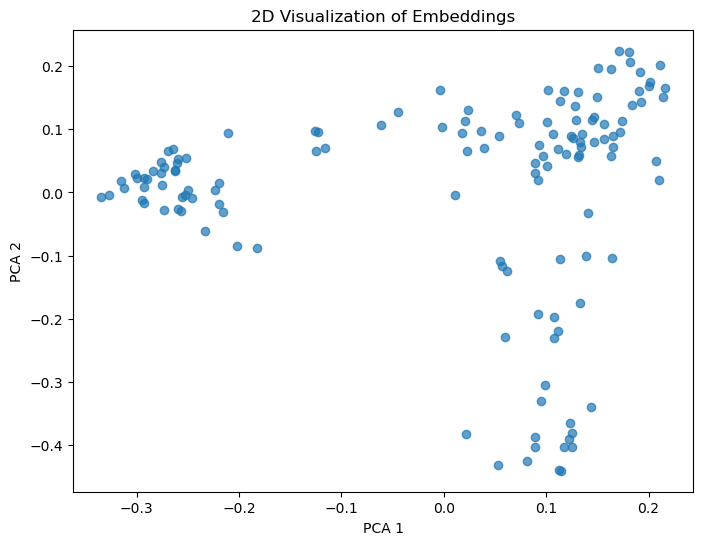

In [428]:
if embeddings_array.size > 0: 
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings_array)

    # Plot embeddings
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title("2D Visualization of Embeddings")
    plt.show()
else:
    print("No embeddings available for PCA visualization.")


# Manully testing to retrive 2st attempt just checking 👌

In [430]:
data = chroma_client.get_collection(name="my_dataaaa")

In [431]:
query_embedding =  embeddings_model.embed_query("Quelles sont les documents de stage obligatoire?")

results = data.query(
    query_embeddings=[query_embedding],  
    n_results=50
)

In [432]:
results

{'ids': [['48768f1f-e97a-439f-94aa-907b00830cad',
   '20570c59-d1ed-4443-993f-ad853c867ccc',
   '3df608c1-81d4-4552-9d6a-d47451cff0ad',
   '946eff34-b1ac-4650-84a9-cca9e2620e85',
   '1d0b3f87-bbab-4b89-802e-2878899ba22e',
   'c6236836-ec17-40e7-8715-b3ab6c05fd3c',
   '210d4e8a-7f02-4ed4-8444-8eaf95c182fb',
   '6aad5522-2efb-4915-90a1-dcd17df5e237',
   '5992d59d-f0ce-4238-8673-5a8a76ac3cf0',
   '40365b04-da4b-4918-8663-9a5b54a9f829',
   '92952d2f-954f-4b6f-88a5-debf117e1d65',
   '07d58ad9-10b8-44e5-9a44-2717ff4f17cc',
   'a639ae62-af72-48a3-b061-385588ce102a',
   'b3f3bd16-ec22-48d4-826b-972c3e701b77',
   '201a130c-a847-48a9-89b1-e00d9de4c92f',
   'c5bdc4e4-4bf7-4fe6-969b-8e24b3b83a39',
   '38410e24-308e-4ea4-8ccc-6d2c0ac86c61',
   'afb5acaf-7ee1-44a5-a010-a8b920ed95be',
   '758107d4-abca-4156-a6bd-ca09509bd9d5',
   '4837c9b4-ade6-435c-bfbf-c489836bbdfc',
   '433f4ee2-dfdf-4c19-b496-1b1b9a2e282e',
   'ef3d8052-0a55-48ca-892e-abc1268ae0bd',
   'e47f97de-27b9-46d8-a3d9-c18c32652721',
   '

In [783]:
chroma_client = chromadb.PersistentClient(path="chroma_db")
collections = chroma_client.list_collections()
print("Available collections:", collections)  
if "my_dataaaa" in collections:
    collection = chroma_client.get_collection(name="my_dataaaa")
    print(" Successfully loaded collection:", collection)
else:
    print("Collection 'my_dataaaa' does not exist.", collections)


Available collections: ['langchain', 'my_dataaaa']
 Successfully loaded collection: Collection(name=my_dataaaa)
